### Importação dos dados



In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
from datetime import datetime
from matplotlib.ticker import FuncFormatter
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display, HTML



urls = {
    'Loja 1': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    'Loja 2': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    'Loja 3': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    'Loja 4': "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
}




lojas_tratadas = {}

for nome_loja, url in urls.items():
    df = pd.read_csv(url)
    df['Loja'] = nome_loja

    df['Data da Compra'] = pd.to_datetime(df['Data da Compra'], dayfirst=True, errors='coerce')
    df['Mês'] = df['Data da Compra'].dt.month
    df['Ano'] = df['Data da Compra'].dt.year
    df['Mês-Ano'] = df['Data da Compra'].dt.to_period('M')

    df['Preço'] = df['Preço'].abs()
    df['Frete'] = df['Frete'].abs()
    df['Valor Total'] = (df['Preço'] + df['Frete']).round(2)

    df['Avaliação da compra'] = df['Avaliação da compra'].clip(1, 5)

    df['Quantidade de parcelas'] = df['Quantidade de parcelas'].clip(1, 24)

    df['Categoria do Produto'] = df['Categoria do Produto'].str.strip().str.title()
    df['Local da compra'] = df['Local da compra'].str.strip().str.upper()
    df['Tipo de pagamento'] = df['Tipo de pagamento'].str.strip().str.lower()

    print(f"\nDados nulos em {nome_loja}:")
    print(df.isnull().sum())

    lojas_tratadas[nome_loja] = df

loja1 = lojas_tratadas['Loja 1']
loja2 = lojas_tratadas['Loja 2']
loja3 = lojas_tratadas['Loja 3']
loja4 = lojas_tratadas['Loja 4']
df_vendas = pd.concat(lojas_tratadas.values(), ignore_index=True)

print(loja1.head())
print(loja2.head())
print(loja3.head())
print(loja4.head())


Dados nulos em Loja 1:
Produto                   0
Categoria do Produto      0
Preço                     0
Frete                     0
Data da Compra            0
Vendedor                  0
Local da compra           0
Avaliação da compra       0
Tipo de pagamento         0
Quantidade de parcelas    0
lat                       0
lon                       0
Loja                      0
Mês                       0
Ano                       0
Mês-Ano                   0
Valor Total               0
dtype: int64

Dados nulos em Loja 2:
Produto                   0
Categoria do Produto      0
Preço                     0
Frete                     0
Data da Compra            0
Vendedor                  0
Local da compra           0
Avaliação da compra       0
Tipo de pagamento         0
Quantidade de parcelas    0
lat                       0
lon                       0
Loja                      0
Mês                       0
Ano                       0
Mês-Ano                   0
Valor Total    

#1. Análise do faturamento


##1.1 Análise do faturamento básico


Faturamento Total por Loja:
Loja 1: R$ 1.616.346,99
Loja 2: R$ 1.567.773,29
Loja 3: R$ 1.542.047,52
Loja 4: R$ 1.458.253,56

Top 5 Produtos por Faturamento:
Eletronicos: R$ 2.332.048,06
Eletrodomesticos: R$ 1.860.198,65
Moveis: R$ 1.064.149,67
Instrumentos Musicais: R$ 489.701,46
Esporte E Lazer: R$ 200.891,95

Top 3 Estados por Faturamento:
SP: R$ 2.548.779,23
RJ: R$ 812.542,88
MG: R$ 727.688,28


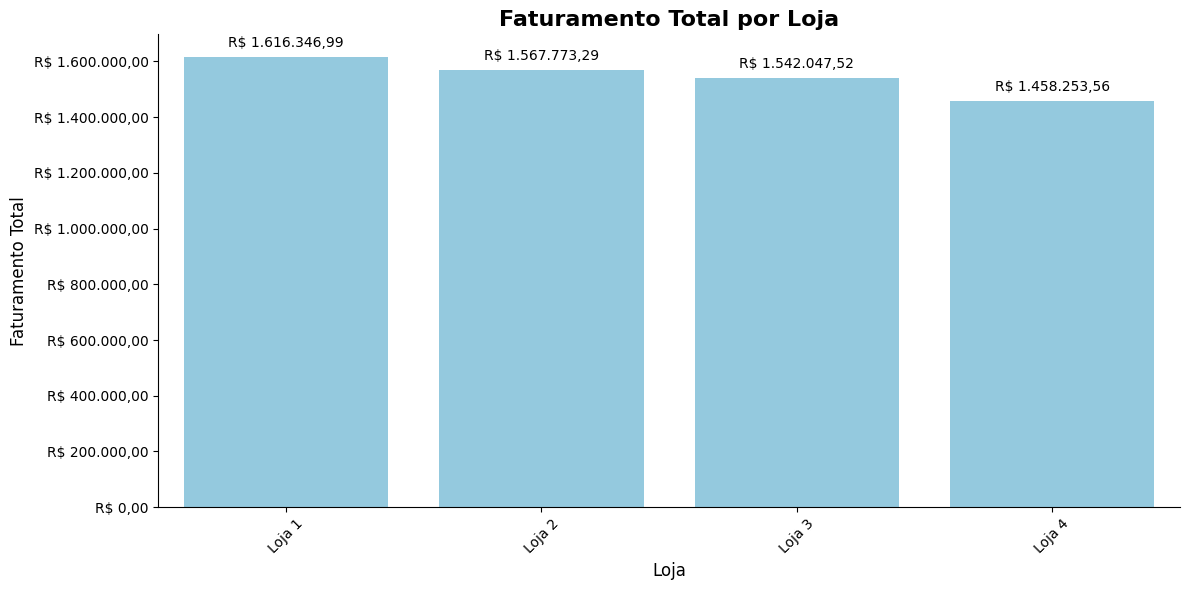

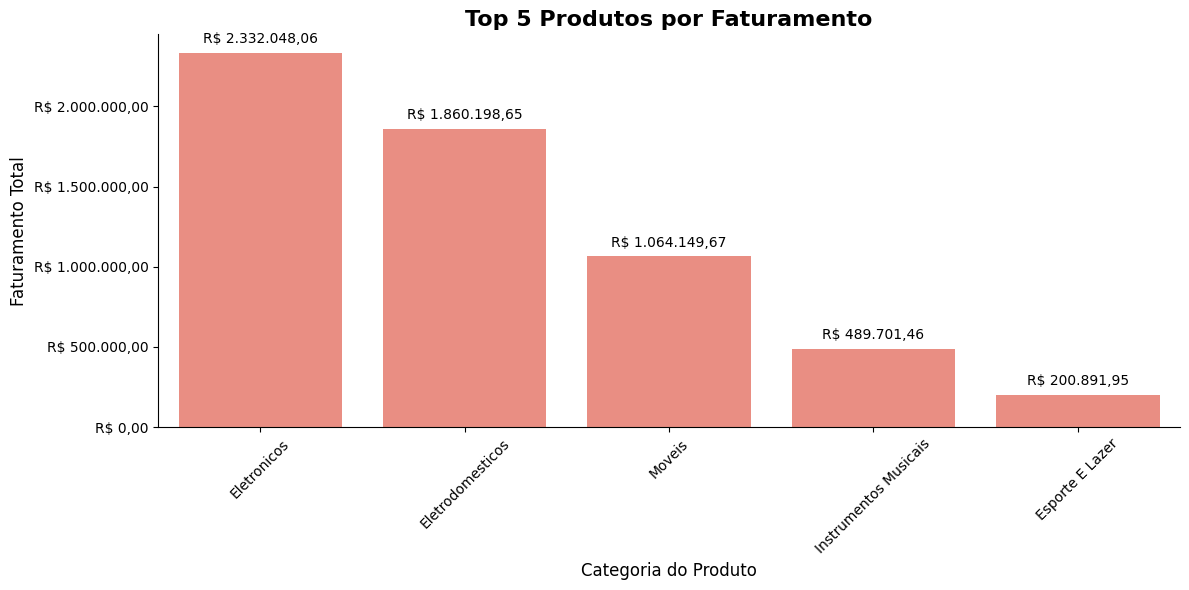

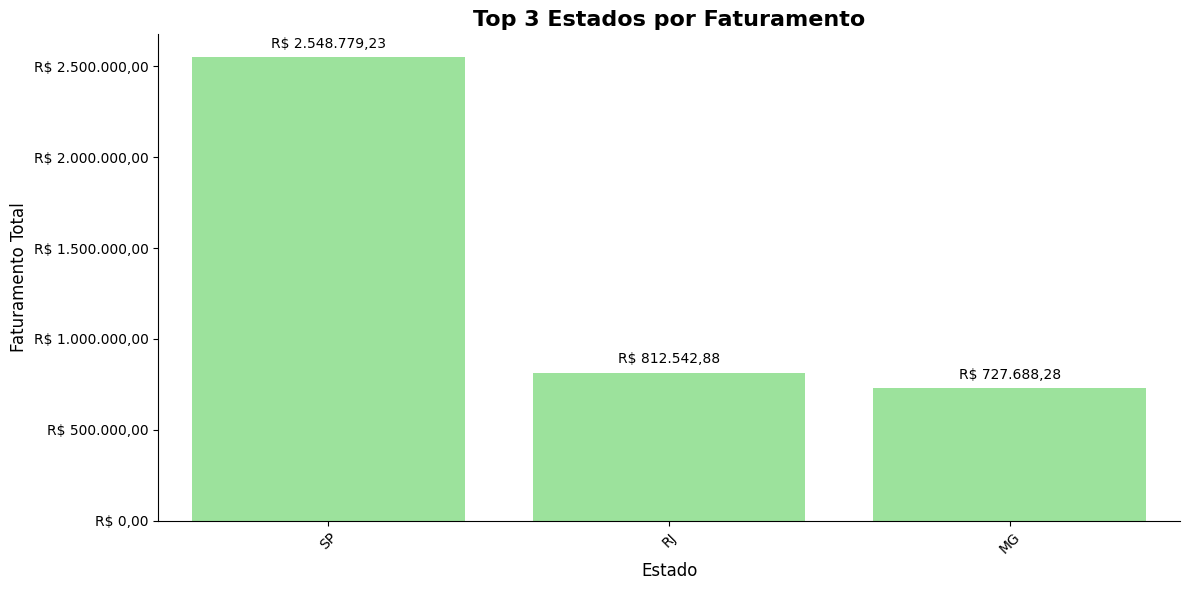

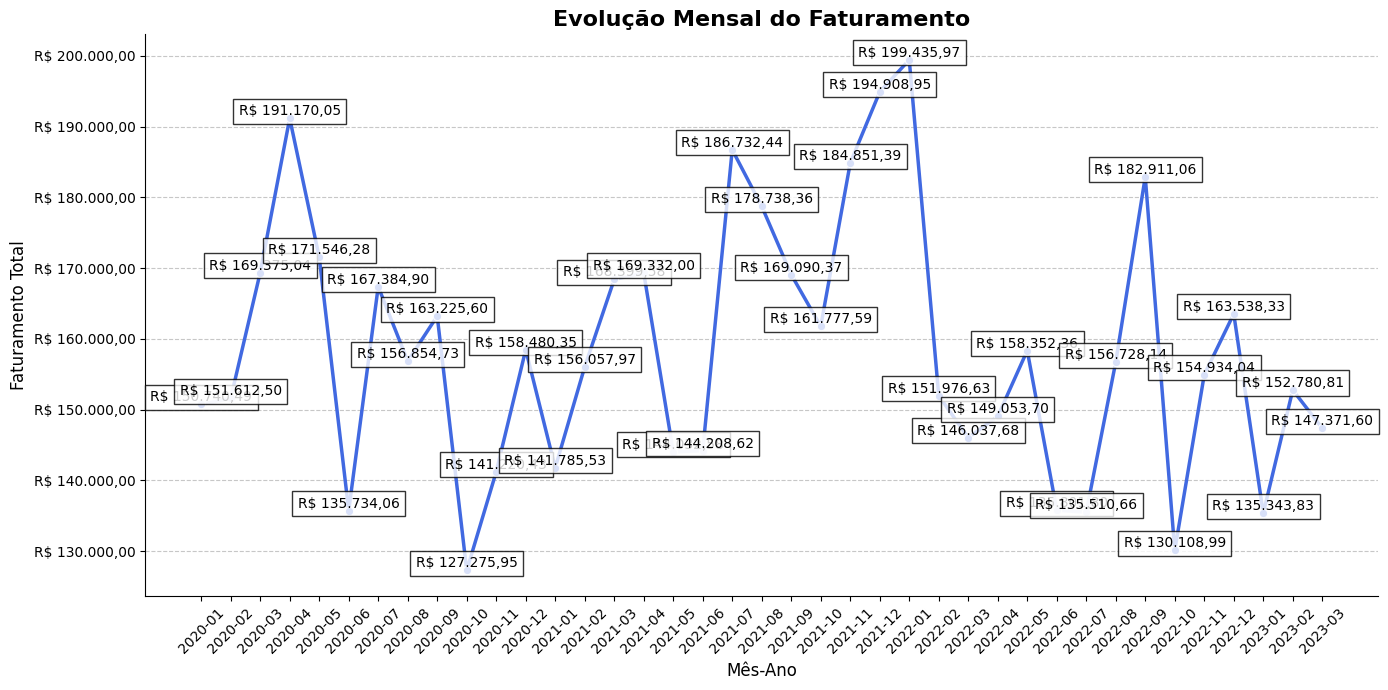

In [2]:
def formatar_moeda(valor, pos=None):
    return f'R$ {valor:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')

def calcular_faturamento_por_loja(lojas):
    return {nome: df['Valor Total'].sum() for nome, df in lojas.items()}

def top_produtos_por_faturamento(lojas, n=5):
    produtos = {}
    for df in lojas.values():
        for produto, grupo in df.groupby('Categoria do Produto'):
            produtos[produto] = produtos.get(produto, 0) + grupo['Valor Total'].sum()
    return dict(sorted(produtos.items(), key=lambda item: item[1], reverse=True)[:n])

def top_estados_por_faturamento(lojas, n=3):
    estados = {}
    for df in lojas.values():
        for estado, grupo in df.groupby('Local da compra'):
            estados[estado] = estados.get(estado, 0) + grupo['Valor Total'].sum()
    return dict(sorted(estados.items(), key=lambda item: item[1], reverse=True)[:n])

def evolucao_mensal_faturamento(lojas):
    evolucao = {}
    for df in lojas.values():
        for mes_ano, grupo in df.groupby('Mês-Ano'):
            evolucao[mes_ano] = evolucao.get(mes_ano, 0) + grupo['Valor Total'].sum()
    return dict(sorted(evolucao.items()))

def plotar_grafico_barras(dados, titulo, xlabel, ylabel, cor='skyblue', formato_moeda=True):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(dados.keys()), y=list(dados.values()), color=cor)
    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)

    if formato_moeda:
        ax.yaxis.set_major_formatter(FuncFormatter(formatar_moeda))

    for p in ax.patches:
        valor = p.get_height()
        if formato_moeda:
            texto = formatar_moeda(valor)
        else:
            texto = f'{valor:,.0f}'
        ax.annotate(texto,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=10)

    sns.despine()
    plt.tight_layout()
    plt.show()

def plotar_evolucao_mensal(dados):
    meses = [str(period) for period in dados.keys()]
    valores = list(dados.values())

    plt.figure(figsize=(14, 7))
    ax = sns.lineplot(x=meses, y=valores,
                      marker='o', linewidth=2.5, color='royalblue')

    plt.title('Evolução Mensal do Faturamento', fontsize=16, fontweight='bold')
    plt.xlabel('Mês-Ano', fontsize=12)
    plt.ylabel('Faturamento Total', fontsize=12)
    plt.xticks(rotation=45)

    ax.yaxis.set_major_formatter(FuncFormatter(formatar_moeda))

    for x, y in zip(meses, valores):
        plt.text(x, y, formatar_moeda(y),
                 ha='center', va='bottom',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    sns.despine()
    plt.tight_layout()
    plt.show()

faturamento_lojas = calcular_faturamento_por_loja(lojas_tratadas)
top_produtos = top_produtos_por_faturamento(lojas_tratadas)
top_estados = top_estados_por_faturamento(lojas_tratadas)
evolucao_mensal = evolucao_mensal_faturamento(lojas_tratadas)

print("\nFaturamento Total por Loja:")
for loja, valor in faturamento_lojas.items():
    print(f"{loja}: {formatar_moeda(valor)}")

print("\nTop 5 Produtos por Faturamento:")
for produto, valor in top_produtos.items():
    print(f"{produto}: {formatar_moeda(valor)}")

print("\nTop 3 Estados por Faturamento:")
for estado, valor in top_estados.items():
    print(f"{estado}: {formatar_moeda(valor)}")

plotar_grafico_barras(faturamento_lojas,
                     'Faturamento Total por Loja',
                     'Loja', 'Faturamento Total')

plotar_grafico_barras(top_produtos,
                     'Top 5 Produtos por Faturamento',
                     'Categoria do Produto', 'Faturamento Total',
                     cor='salmon')

plotar_grafico_barras(top_estados,
                     'Top 3 Estados por Faturamento',
                     'Estado', 'Faturamento Total',
                     cor='lightgreen')

plotar_evolucao_mensal(evolucao_mensal)

##1.2 Análise detalhada por loja


ANÁLISE DETALHADA: Loja 1

Top 5 Produtos por Faturamento (Loja 1):
Eletronicos: R$ 603.278,21
Eletrodomesticos: R$ 510.678,32
Moveis: R$ 263.505,30
Instrumentos Musicais: R$ 128.243,47
Esporte E Lazer: R$ 55.216,64


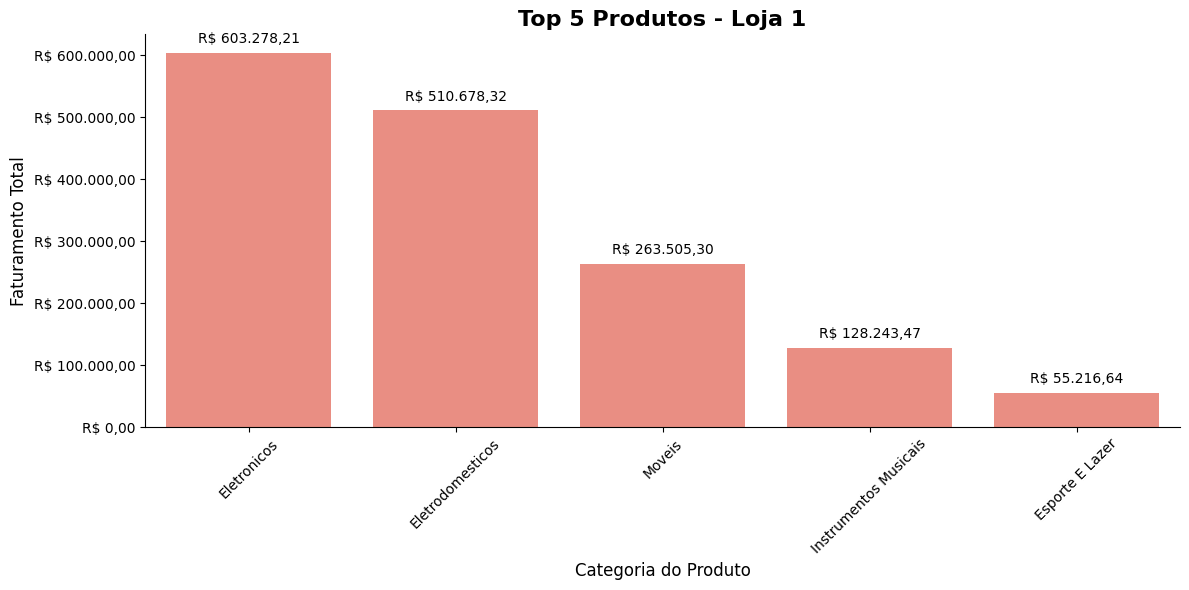


Faturamento por Meio de Pagamento (Loja 1):
cartao_credito: R$ 1.180.673,13
boleto: R$ 326.607,00
cupom: R$ 90.061,71
cartao_debito: R$ 19.005,15


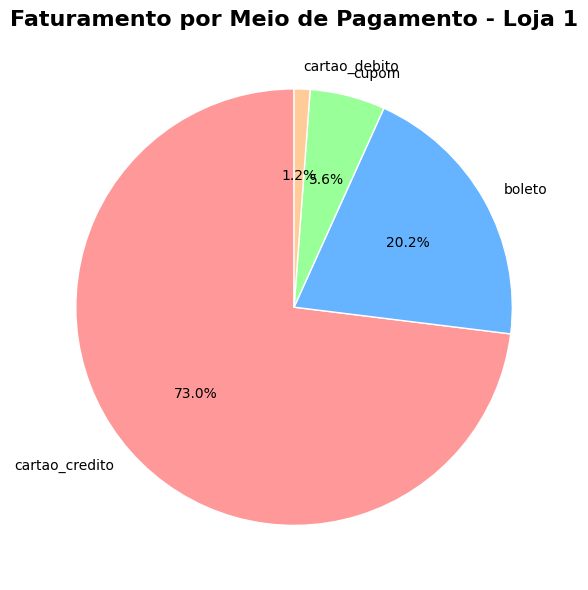


Média de Avaliação (Loja 1): 3.98


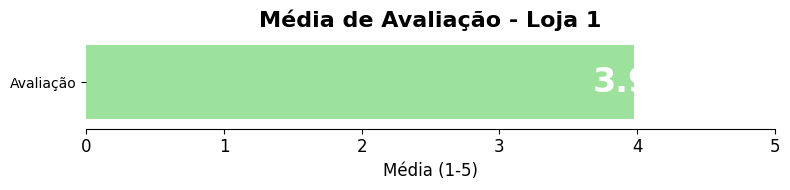


Evolução Mensal do Faturamento (Loja 1):
2020-01: R$ 46.450,18
2020-02: R$ 56.277,84
2020-03: R$ 44.311,16
2020-04: R$ 47.297,89
2020-05: R$ 54.174,23
2020-06: R$ 36.927,98
2020-07: R$ 49.282,12
2020-08: R$ 43.731,99
2020-09: R$ 42.483,77
2020-10: R$ 29.717,40
2020-11: R$ 27.929,84
2020-12: R$ 39.655,23
2021-01: R$ 35.926,42
2021-02: R$ 45.794,69
2021-03: R$ 41.228,69
2021-04: R$ 31.748,45
2021-05: R$ 39.063,44
2021-06: R$ 43.285,09
2021-07: R$ 51.754,05
2021-08: R$ 48.934,99
2021-09: R$ 62.563,36
2021-10: R$ 38.673,58
2021-11: R$ 36.735,58
2021-12: R$ 32.747,88
2022-01: R$ 36.862,62
2022-02: R$ 39.035,28
2022-03: R$ 35.603,04
2022-04: R$ 31.433,98
2022-05: R$ 35.219,13
2022-06: R$ 35.064,71
2022-07: R$ 38.270,19
2022-08: R$ 39.062,35
2022-09: R$ 52.115,16
2022-10: R$ 20.633,30
2022-11: R$ 33.218,35
2022-12: R$ 48.051,70
2023-01: R$ 40.631,76
2023-02: R$ 52.313,21
2023-03: R$ 52.136,36


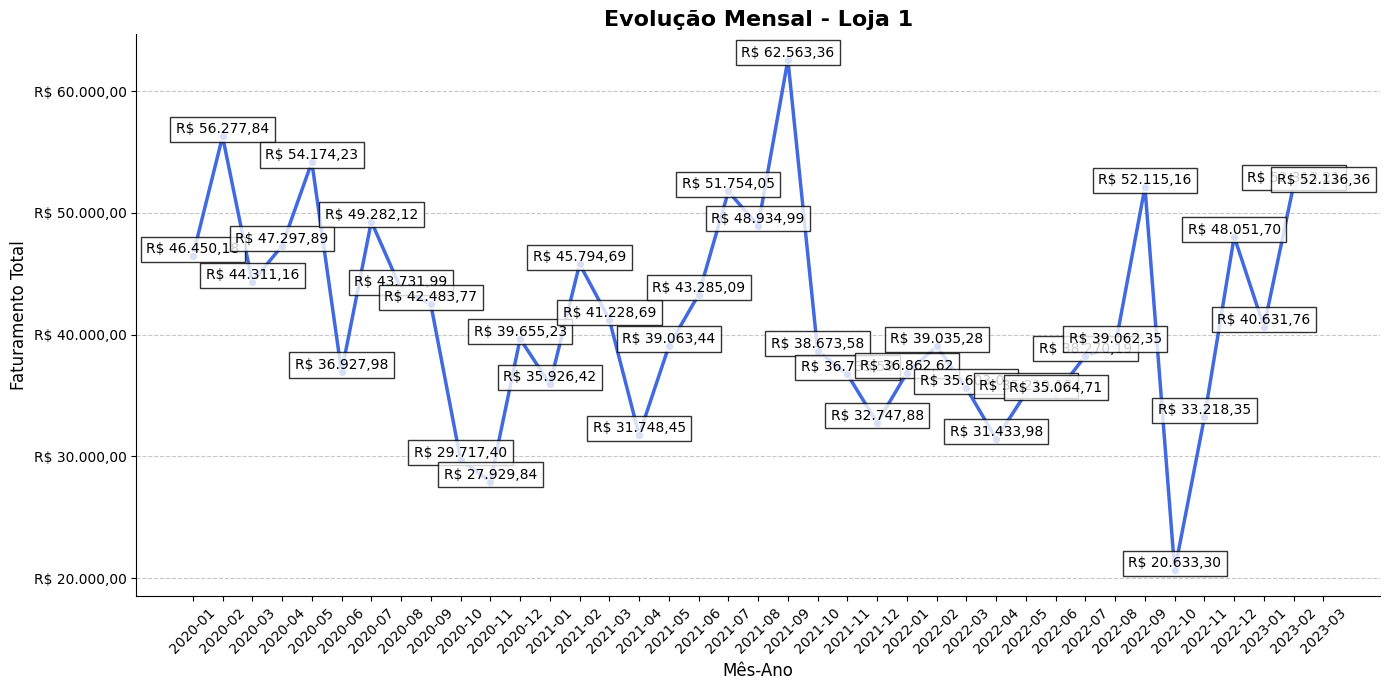


ANÁLISE DETALHADA: Loja 2

Top 5 Produtos por Faturamento (Loja 2):
Eletronicos: R$ 576.858,26
Eletrodomesticos: R$ 489.499,10
Moveis: R$ 247.817,06
Instrumentos Musicais: R$ 147.397,12
Esporte E Lazer: R$ 48.828,92


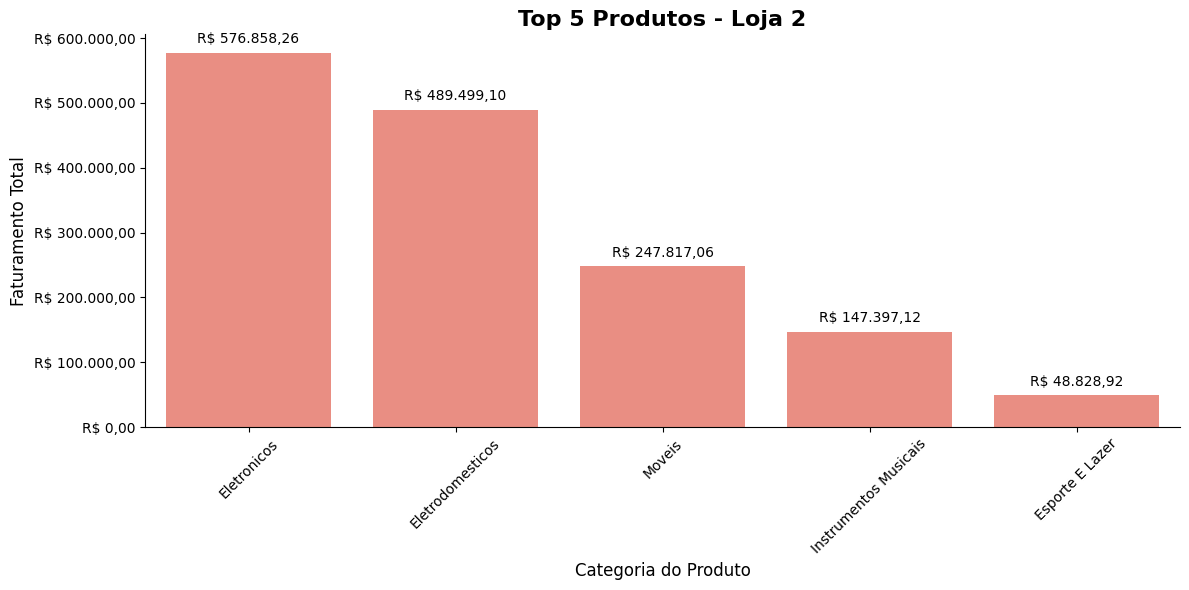


Faturamento por Meio de Pagamento (Loja 2):
cartao_credito: R$ 1.146.911,13
boleto: R$ 295.949,57
cupom: R$ 108.678,15
cartao_debito: R$ 16.234,44


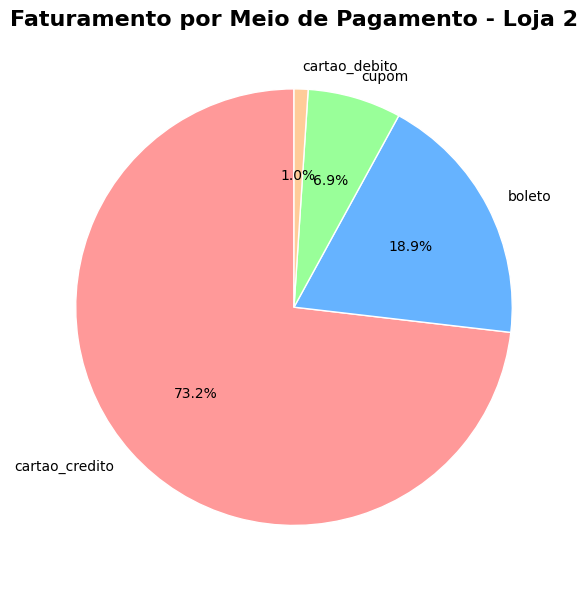


Média de Avaliação (Loja 2): 4.04


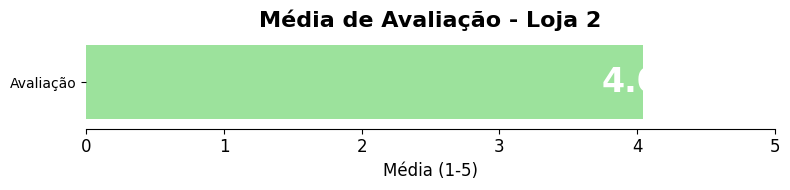


Evolução Mensal do Faturamento (Loja 2):
2020-01: R$ 43.731,80
2020-02: R$ 24.417,19
2020-03: R$ 42.868,58
2020-04: R$ 38.817,22
2020-05: R$ 35.791,67
2020-06: R$ 36.600,09
2020-07: R$ 33.105,72
2020-08: R$ 32.987,72
2020-09: R$ 43.747,72
2020-10: R$ 46.693,53
2020-11: R$ 31.693,63
2020-12: R$ 39.723,82
2021-01: R$ 40.970,03
2021-02: R$ 38.331,30
2021-03: R$ 34.619,24
2021-04: R$ 46.296,23
2021-05: R$ 39.127,49
2021-06: R$ 32.007,10
2021-07: R$ 48.610,05
2021-08: R$ 44.445,42
2021-09: R$ 42.544,95
2021-10: R$ 34.044,86
2021-11: R$ 40.769,29
2021-12: R$ 51.347,27
2022-01: R$ 57.133,02
2022-02: R$ 32.817,14
2022-03: R$ 33.140,26
2022-04: R$ 48.603,23
2022-05: R$ 48.792,91
2022-06: R$ 33.354,10
2022-07: R$ 33.170,30
2022-08: R$ 40.957,51
2022-09: R$ 46.064,04
2022-10: R$ 42.753,64
2022-11: R$ 39.459,67
2022-12: R$ 46.850,01
2023-01: R$ 35.365,42
2023-02: R$ 47.970,08
2023-03: R$ 38.050,04


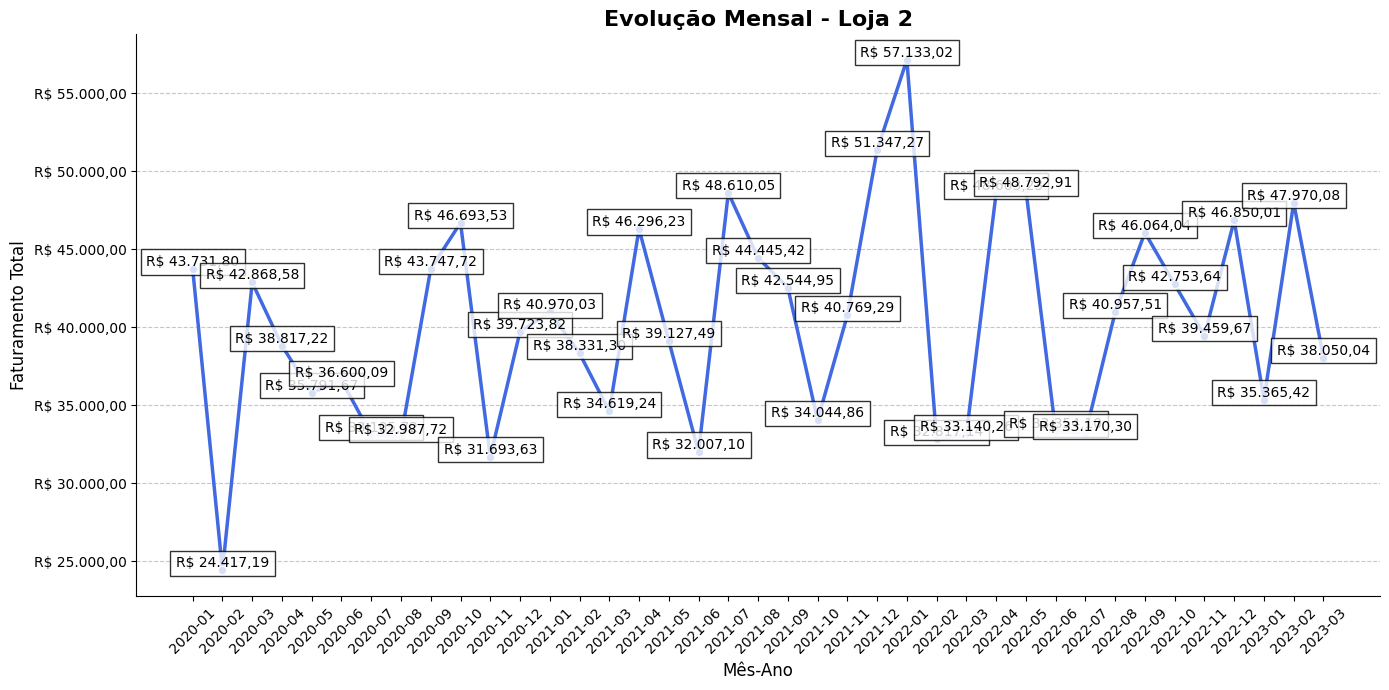


ANÁLISE DETALHADA: Loja 3

Top 5 Produtos por Faturamento (Loja 3):
Eletronicos: R$ 576.840,37
Eletrodomesticos: R$ 462.310,44
Moveis: R$ 282.475,18
Instrumentos Musicais: R$ 108.652,53
Esporte E Lazer: R$ 50.020,57


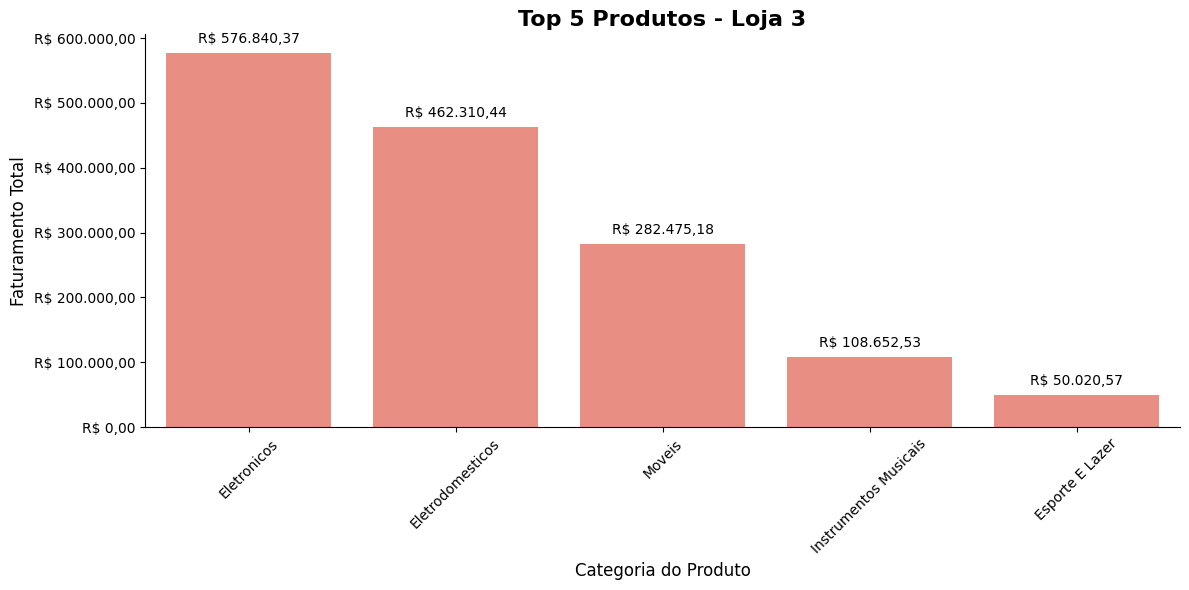


Faturamento por Meio de Pagamento (Loja 3):
cartao_credito: R$ 1.130.001,00
boleto: R$ 321.999,90
cupom: R$ 66.572,14
cartao_debito: R$ 23.474,48


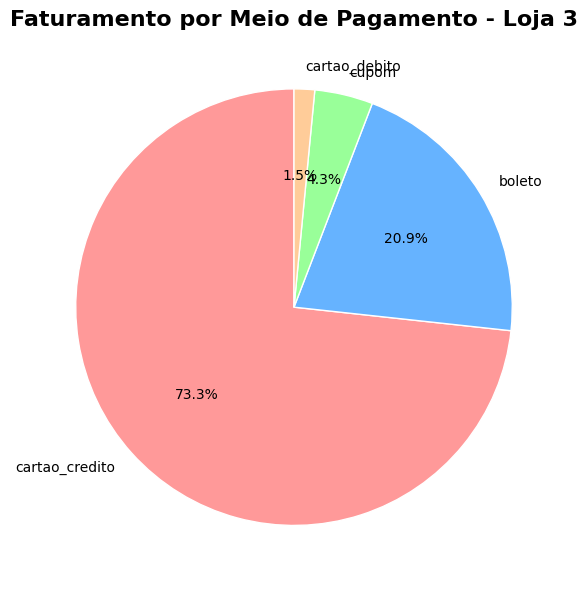


Média de Avaliação (Loja 3): 4.05


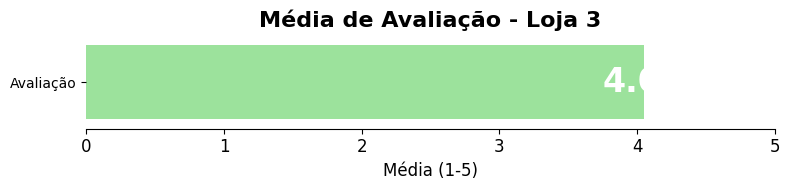


Evolução Mensal do Faturamento (Loja 3):
2020-01: R$ 33.433,44
2020-02: R$ 38.745,87
2020-03: R$ 42.153,04
2020-04: R$ 49.626,74
2020-05: R$ 36.671,78
2020-06: R$ 24.514,93
2020-07: R$ 47.185,06
2020-08: R$ 36.326,61
2020-09: R$ 37.427,31
2020-10: R$ 26.029,42
2020-11: R$ 32.109,60
2020-12: R$ 47.476,24
2021-01: R$ 31.838,56
2021-02: R$ 28.451,55
2021-03: R$ 39.286,21
2021-04: R$ 34.832,49
2021-05: R$ 37.214,14
2021-06: R$ 45.153,54
2021-07: R$ 37.341,72
2021-08: R$ 48.981,58
2021-09: R$ 19.819,89
2021-10: R$ 51.018,49
2021-11: R$ 68.943,10
2021-12: R$ 66.904,85
2022-01: R$ 57.256,82
2022-02: R$ 34.571,94
2022-03: R$ 33.562,08
2022-04: R$ 39.856,44
2022-05: R$ 44.822,94
2022-06: R$ 35.673,63
2022-07: R$ 43.173,89
2022-08: R$ 39.019,98
2022-09: R$ 41.232,17
2022-10: R$ 39.219,58
2022-11: R$ 42.095,44
2022-12: R$ 41.736,39
2023-01: R$ 31.538,83
2023-02: R$ 24.903,29
2023-03: R$ 31.897,94


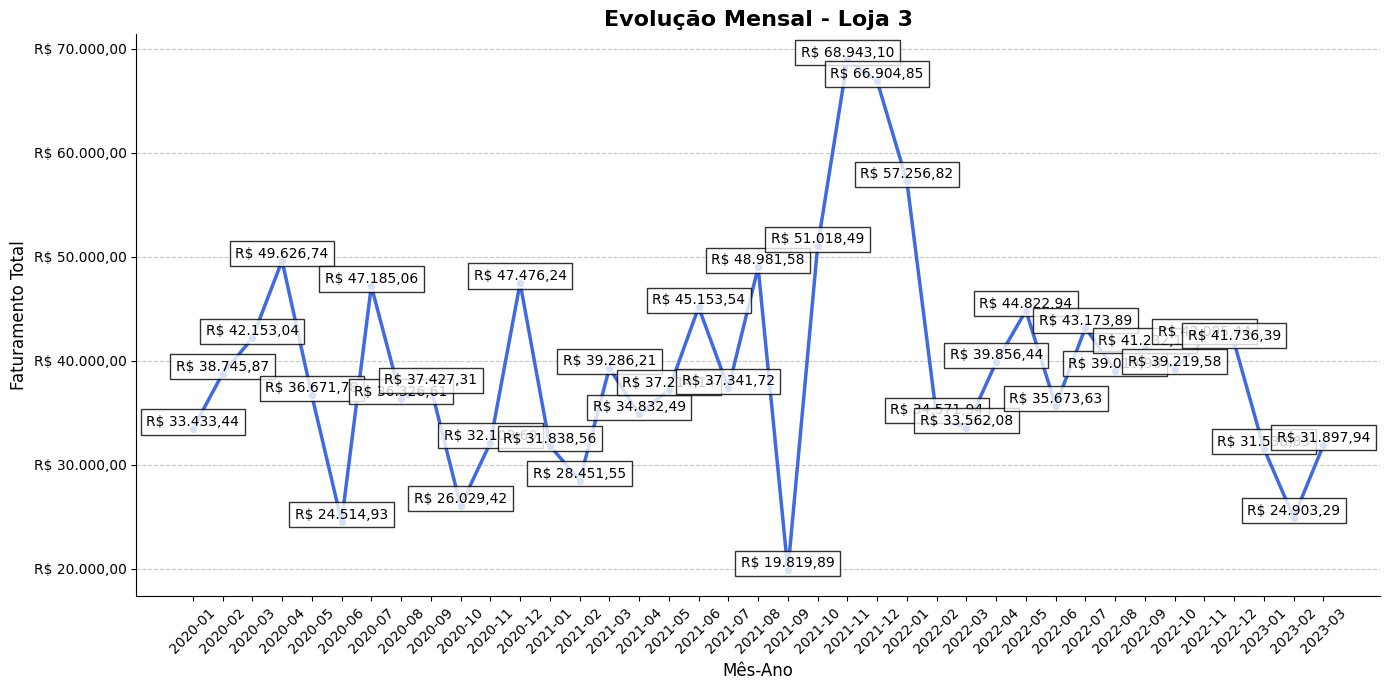


ANÁLISE DETALHADA: Loja 4

Top 5 Produtos por Faturamento (Loja 4):
Eletronicos: R$ 575.071,22
Eletrodomesticos: R$ 397.710,79
Moveis: R$ 270.352,13
Instrumentos Musicais: R$ 105.408,34
Esporte E Lazer: R$ 46.825,82


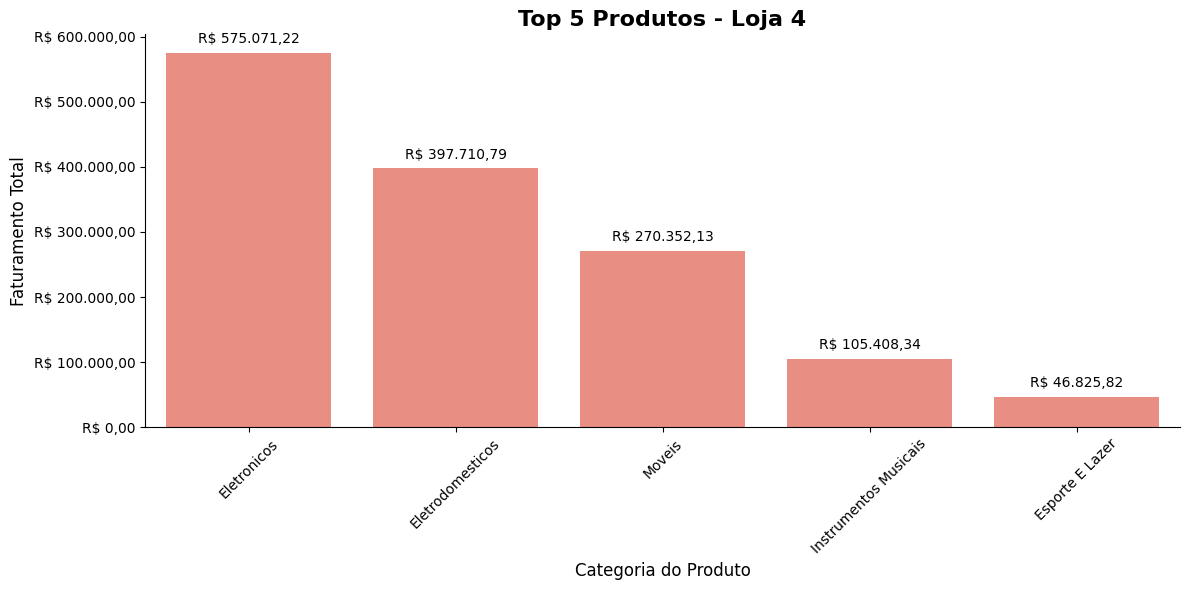


Faturamento por Meio de Pagamento (Loja 4):
cartao_credito: R$ 1.079.657,63
boleto: R$ 292.007,27
cupom: R$ 65.992,35
cartao_debito: R$ 20.596,31


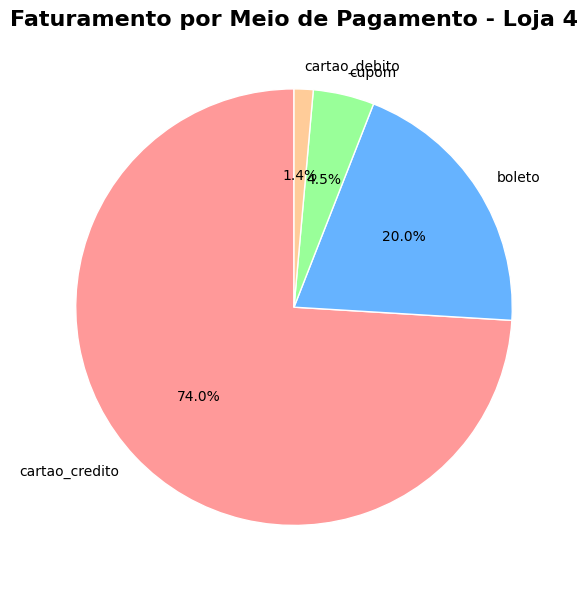


Média de Avaliação (Loja 4): 4.00


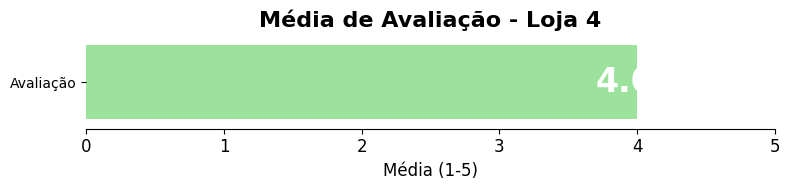


Evolução Mensal do Faturamento (Loja 4):
2020-01: R$ 27.125,07
2020-02: R$ 32.171,60
2020-03: R$ 40.042,26
2020-04: R$ 55.428,20
2020-05: R$ 44.908,60
2020-06: R$ 37.691,06
2020-07: R$ 37.812,00
2020-08: R$ 43.808,41
2020-09: R$ 39.566,80
2020-10: R$ 24.835,60
2020-11: R$ 49.487,36
2020-12: R$ 31.625,06
2021-01: R$ 33.050,52
2021-02: R$ 43.480,43
2021-03: R$ 53.265,44
2021-04: R$ 56.454,83
2021-05: R$ 28.627,51
2021-06: R$ 23.762,89
2021-07: R$ 49.026,62
2021-08: R$ 36.376,37
2021-09: R$ 44.162,17
2021-10: R$ 38.040,66
2021-11: R$ 38.403,42
2021-12: R$ 43.908,95
2022-01: R$ 48.183,51
2022-02: R$ 45.552,27
2022-03: R$ 43.732,30
2022-04: R$ 29.160,05
2022-05: R$ 29.517,38
2022-06: R$ 31.709,36
2022-07: R$ 20.896,28
2022-08: R$ 37.688,30
2022-09: R$ 43.499,69
2022-10: R$ 27.502,47
2022-11: R$ 40.160,58
2022-12: R$ 26.900,23
2023-01: R$ 27.807,82
2023-02: R$ 27.594,23
2023-03: R$ 25.287,26


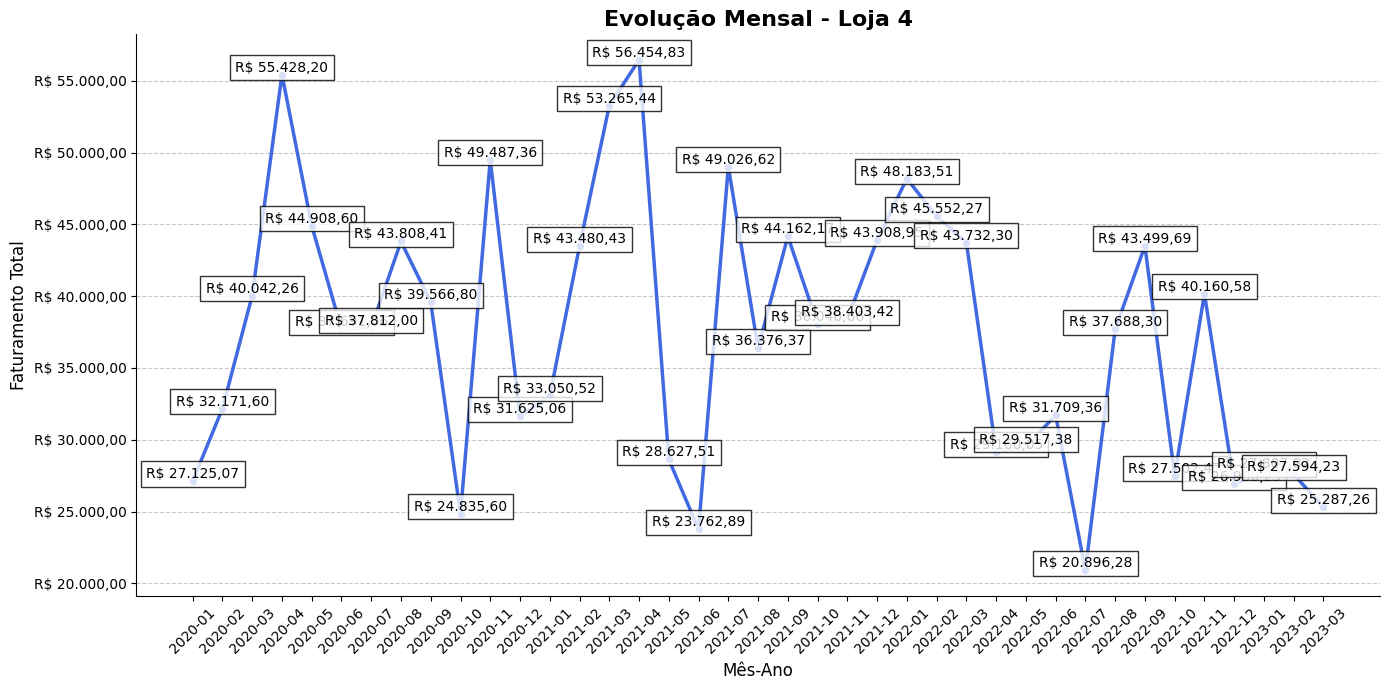

In [3]:
def faturamento_por_produto_loja(df_loja, top_n=5):
    return df_loja.groupby('Categoria do Produto')['Valor Total'].sum().nlargest(top_n).to_dict()

def faturamento_por_pagamento_loja(df_loja):
    return df_loja.groupby('Tipo de pagamento')['Valor Total'].sum().sort_values(ascending=False).to_dict()

def media_avaliacao_por_loja(df_loja):
    return df_loja['Avaliação da compra'].mean().round(2)

def evolucao_mensal_por_loja(df_loja):
    return df_loja.groupby('Mês-Ano')['Valor Total'].sum().sort_index()

def plotar_grafico_pizza(dados, titulo, colors=None):
    if colors is None:
        colors = sns.color_palette('pastel')[0:len(dados)]

    plt.figure(figsize=(10, 6))
    plt.pie(dados.values(), labels=dados.keys(), autopct='%1.1f%%',
            colors=colors, startangle=90, wedgeprops={'edgecolor': 'white'})
    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plotar_media_avaliacao(media, titulo):
    plt.figure(figsize=(8, 2))
    ax = sns.barplot(x=[media], y=['Avaliação'], color='lightgreen')

    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.xlim(0, 5)
    plt.xlabel('Média (1-5)', fontsize=12)
    plt.ylabel('')
    plt.xticks(fontsize=12)

    ax.text(media, 0, f"{media:.2f}",
            ha='center', va='center',
            color='white', fontsize=24, fontweight='bold')

    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

for nome_loja, df_loja in lojas_tratadas.items():
    print(f"\n{'='*50}")
    print(f"ANÁLISE DETALHADA: {nome_loja}")
    print(f"{'='*50}")

    fat_produto = faturamento_por_produto_loja(df_loja)
    print(f"\nTop 5 Produtos por Faturamento ({nome_loja}):")
    for produto, valor in fat_produto.items():
        print(f"{produto}: {formatar_moeda(valor)}")

    plotar_grafico_barras(fat_produto,
                         f'Top 5 Produtos - {nome_loja}',
                         'Categoria do Produto', 'Faturamento Total',
                         cor='salmon')

    fat_pagamento = faturamento_por_pagamento_loja(df_loja)
    print(f"\nFaturamento por Meio de Pagamento ({nome_loja}):")
    for pagamento, valor in fat_pagamento.items():
        print(f"{pagamento}: {formatar_moeda(valor)}")

    plotar_grafico_pizza(fat_pagamento,
                        f'Faturamento por Meio de Pagamento - {nome_loja}',
                        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

    media_avaliacao = media_avaliacao_por_loja(df_loja)
    print(f"\nMédia de Avaliação ({nome_loja}): {media_avaliacao:.2f}")

    plotar_media_avaliacao(media_avaliacao,
                          f'Média de Avaliação - {nome_loja}')

    evolucao = evolucao_mensal_por_loja(df_loja)
    print(f"\nEvolução Mensal do Faturamento ({nome_loja}):")
    for mes, valor in evolucao.items():
        print(f"{mes}: {formatar_moeda(valor)}")

    plt.figure(figsize=(14, 7))
    ax = sns.lineplot(x=[str(period) for period in evolucao.index],
                      y=evolucao.values,
                      marker='o', linewidth=2.5, color='royalblue')

    plt.title(f'Evolução Mensal - {nome_loja}', fontsize=16, fontweight='bold')
    plt.xlabel('Mês-Ano', fontsize=12)
    plt.ylabel('Faturamento Total', fontsize=12)
    plt.xticks(rotation=45)
    ax.yaxis.set_major_formatter(FuncFormatter(formatar_moeda))

    for x, y in zip(evolucao.index, evolucao.values):
        plt.text(str(x), y, formatar_moeda(y),
                 ha='center', va='bottom',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine()
    plt.tight_layout()
    plt.show()

##1.3 Análise comparativa entre lojas


COMPARATIVO ENTRE LOJAS:
Loja       Faturamento Total    Média Avaliação Nº Vendas      
------------------------------------------------------------
Loja 1     R$ 1.616.346,99      3.98            2359           
Loja 2     R$ 1.567.773,29      4.04            2359           
Loja 3     R$ 1.542.047,52      4.05            2359           
Loja 4     R$ 1.458.253,56      4.00            2358           


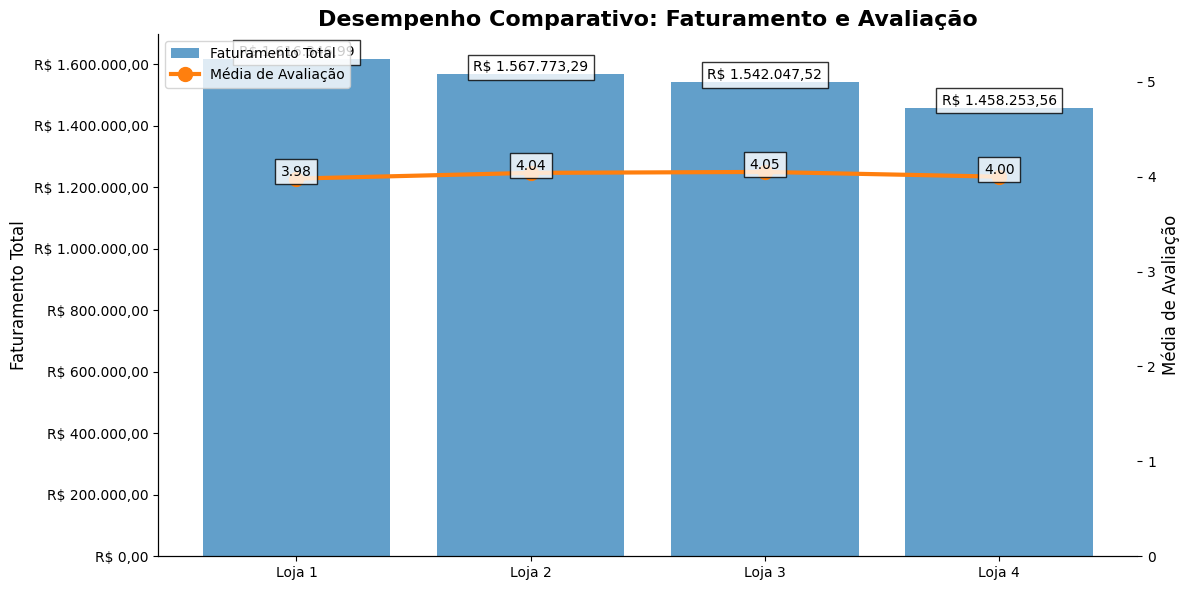

In [4]:
def comparativo_faturamento(lojas):
    return {nome: df['Valor Total'].sum() for nome, df in lojas.items()}

def comparativo_avaliacao(lojas):
    return {nome: df['Avaliação da compra'].mean().round(2) for nome, df in lojas.items()}

def plotar_comparativo_duplo(dados1, dados2, titulo, label1, label2):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(dados1.keys(), dados1.values(), color='#1f77b4', alpha=0.7, label=label1)
    ax1.set_ylabel(label1, fontsize=12)
    ax1.yaxis.set_major_formatter(FuncFormatter(formatar_moeda))

    ax2 = ax1.twinx()
    ax2.plot(dados2.keys(), dados2.values(), color='#ff7f0e', marker='o',
             linewidth=3, markersize=10, label=label2)
    ax2.set_ylabel(label2, fontsize=12)
    ax2.set_ylim(0, 5.5)

    plt.title(titulo, fontsize=16, fontweight='bold')
    fig.tight_layout()

    for i, v in enumerate(dados1.values()):
        ax1.text(i, v, formatar_moeda(v),
                ha='center', va='bottom',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    for x, y in dados2.items():
        ax2.text(x, y, f"{y:.2f}",
                ha='center', va='bottom',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    sns.despine()
    plt.show()


faturamento_comparativo = comparativo_faturamento(lojas_tratadas)
avaliacao_comparativo = comparativo_avaliacao(lojas_tratadas)


print("\nCOMPARATIVO ENTRE LOJAS:")
print("{:<10} {:<20} {:<15} {:<15}".format('Loja', 'Faturamento Total', 'Média Avaliação', 'Nº Vendas'))
print("-"*60)
for loja in faturamento_comparativo:
    print("{:<10} {:<20} {:<15.2f} {:<15}".format(
        loja,
        formatar_moeda(faturamento_comparativo[loja]),
        avaliacao_comparativo[loja],
        len(lojas_tratadas[loja]))
    )


plotar_comparativo_duplo(
    faturamento_comparativo,
    avaliacao_comparativo,
    "Desempenho Comparativo: Faturamento e Avaliação",
    "Faturamento Total",
    "Média de Avaliação"
)


## 1.4 Evolução Mensal

In [6]:
def formatar_moeda(valor):
    if pd.isna(valor):
        return "N/A"
    return f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def calcular_evolucao_mensal(df_loja):
    evolucao = df_loja.groupby('Mês-Ano')['Valor Total'].sum().sort_index()
    evolucao_pct = evolucao.pct_change() * 100
    return evolucao, evolucao_pct

def gerar_relatorio_evolucao(lojas_evolucao):
    resultados = []

    for nome_loja, (evolucao, evolucao_pct) in lojas_evolucao.items():
        crescimento_medio = evolucao_pct.dropna().mean()
        meses_positivos = (evolucao_pct.dropna() > 0).sum()
        total_meses = len(evolucao_pct.dropna())

        resultados.append({
            'Loja': nome_loja,
            'Faturamento Total': evolucao.sum(),
            'Crescimento Médio %': crescimento_medio,
            'Meses com Crescimento': f"{meses_positivos}/{total_meses}",
            'Última Variação %': evolucao_pct.iloc[-1] if len(evolucao_pct) > 1 else None
        })

    df_resultados = pd.DataFrame(resultados)

    df_resultados = df_resultados.sort_values('Crescimento Médio %')

    return df_resultados

lojas_evolucao = {}

print("ANÁLISE DE EVOLUÇÃO MENSAL DAS LOJAS")
print("="*50)

for nome_loja, df_loja in lojas_tratadas.items():
    print(f"\nLOJA: {nome_loja}")
    print("-"*30)

    evolucao, evolucao_pct = calcular_evolucao_mensal(df_loja)
    lojas_evolucao[nome_loja] = (evolucao, evolucao_pct)

    df_evolucao = pd.DataFrame({
        'Mês-Ano': evolucao.index,
        'Faturamento': evolucao.values,
        'Variação %': evolucao_pct.round(1).values
    })

    df_evolucao['Faturamento'] = df_evolucao['Faturamento'].apply(formatar_moeda)
    df_evolucao['Variação %'] = df_evolucao['Variação %'].apply(lambda x: f"{x:.1f}%" if pd.notna(x) else "N/A")

    print("Evolução Mensal Detalhada:")
    print(df_evolucao.to_string(index=False))

    crescimento_medio = evolucao_pct.dropna().mean()
    meses_crescimento = (evolucao_pct.dropna() > 0).sum()
    total_meses = len(evolucao_pct.dropna())

    print(f"\nResumo Performance:")
    print(f"- Crescimento Médio: {crescimento_medio:.1f}%")
    print(f"- Meses com Crescimento: {meses_crescimento}/{total_meses}")
    print(f"- Última Variação: {evolucao_pct.iloc[-1]:.1f}%" if len(evolucao_pct) > 1 else "- Última Variação: N/A")


df_comparativo = gerar_relatorio_evolucao(lojas_evolucao)

df_comparativo['Faturamento Total'] = df_comparativo['Faturamento Total'].apply(formatar_moeda)
df_comparativo['Crescimento Médio %'] = df_comparativo['Crescimento Médio %'].apply(lambda x: f"{x:.1f}%")
df_comparativo['Última Variação %'] = df_comparativo['Última Variação %'].apply(lambda x: f"{x:.1f}%" if pd.notna(x) else "N/A")

print("\n\nRESUMO COMPARATIVO ENTRE LOJAS")
print("="*50)
print(df_comparativo.to_string(index=False))

loja_menor_crescimento = df_comparativo.iloc[0]
print(f"\nLOJA COM MENOR CRESCIMENTO MÉDIO: {loja_menor_crescimento['Loja']}")
print(f"- Crescimento Médio: {loja_menor_crescimento['Crescimento Médio %']}")
print(f"- Meses com Crescimento: {loja_menor_crescimento['Meses com Crescimento']}")
print(f"- Faturamento Total: {loja_menor_crescimento['Faturamento Total']}")

ANÁLISE DE EVOLUÇÃO MENSAL DAS LOJAS

LOJA: Loja 1
------------------------------
Evolução Mensal Detalhada:
Mês-Ano  Faturamento Variação %
2020-01 R$ 46.450,18        N/A
2020-02 R$ 56.277,84      21.2%
2020-03 R$ 44.311,16     -21.3%
2020-04 R$ 47.297,89       6.7%
2020-05 R$ 54.174,23      14.5%
2020-06 R$ 36.927,98     -31.8%
2020-07 R$ 49.282,12      33.5%
2020-08 R$ 43.731,99     -11.3%
2020-09 R$ 42.483,77      -2.9%
2020-10 R$ 29.717,40     -30.0%
2020-11 R$ 27.929,84      -6.0%
2020-12 R$ 39.655,23      42.0%
2021-01 R$ 35.926,42      -9.4%
2021-02 R$ 45.794,69      27.5%
2021-03 R$ 41.228,69     -10.0%
2021-04 R$ 31.748,45     -23.0%
2021-05 R$ 39.063,44      23.0%
2021-06 R$ 43.285,09      10.8%
2021-07 R$ 51.754,05      19.6%
2021-08 R$ 48.934,99      -5.4%
2021-09 R$ 62.563,36      27.8%
2021-10 R$ 38.673,58     -38.2%
2021-11 R$ 36.735,58      -5.0%
2021-12 R$ 32.747,88     -10.9%
2022-01 R$ 36.862,62      12.6%
2022-02 R$ 39.035,28       5.9%
2022-03 R$ 35.603,04      -

# 2. Vendas por Categoria


##2.1 Análise Agregada de Vendas por Categoria


TOP 5 PRODUTOS POR FATURAMENTO 
----------------------------------------------------------------------
Produto                        | Faturamento     | Vendas     | Avaliação 
----------------------------------------------------------------------
Eletronicos                    | R$ 2,33 Mi      | 1772       |      3.99
Eletrodomesticos               | R$ 1,86 Mi      | 1149       |      4.01
Moveis                         | R$ 1,06 Mi      | 1886       |      4.03
Instrumentos Musicais          | R$ 490 mil      | 753        |      4.00
Esporte E Lazer                | R$ 201 mil      | 1113       |      3.99

 TOP 5 PRODUTOS POR QUANTIDADE DE VENDAS 
----------------------------------------------------------------------
Produto                        | Vendas     | Faturamento     | Avaliação 
----------------------------------------------------------------------
Moveis                         | 1886       | R$ 1,06 Mi      |      4.03
Eletronicos                    | 1772       | 

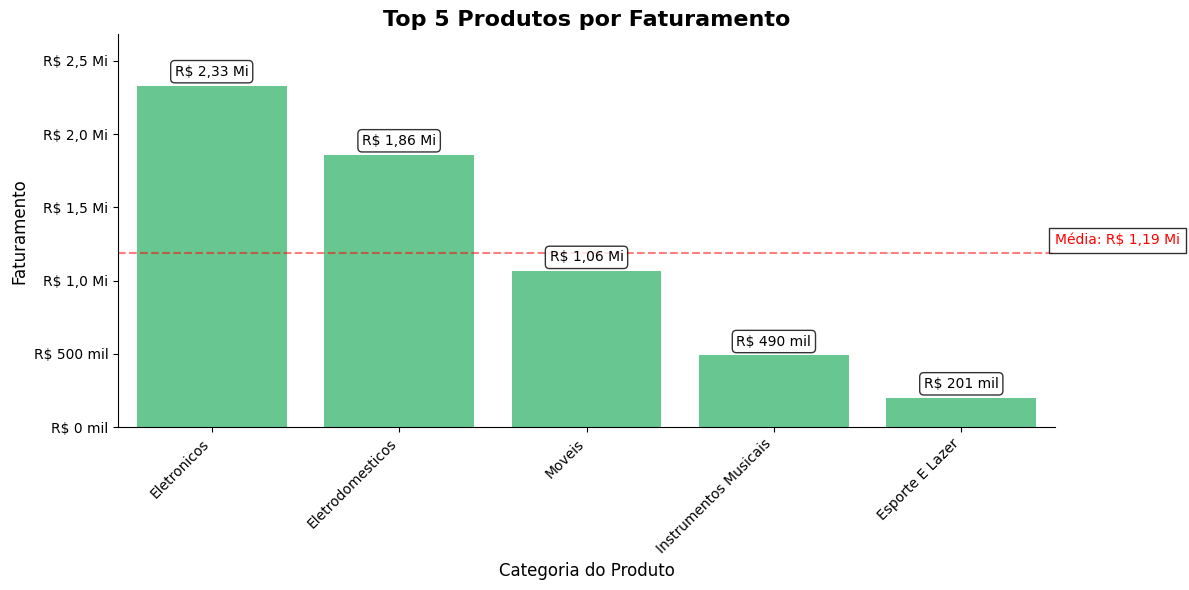

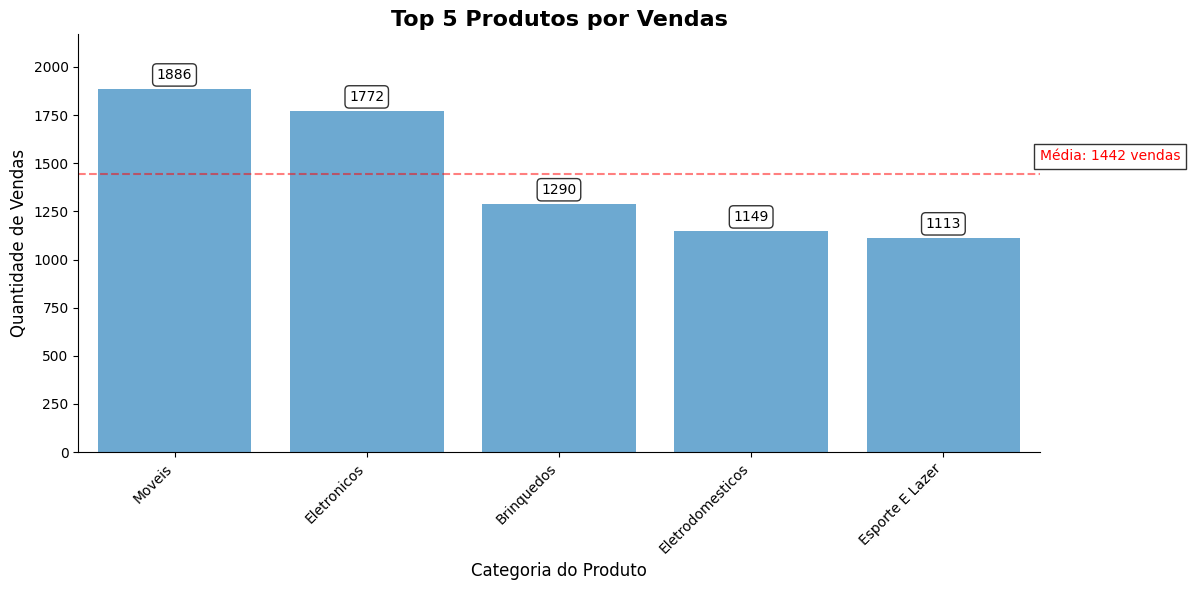

In [7]:
def top_produtos(lojas, top_n=5):
    df_total = pd.concat(lojas.values())

    produtos = df_total.groupby('Categoria do Produto').agg({
        'Valor Total': ['sum', 'count'],
        'Avaliação da compra': 'mean'
    })
    produtos.columns = ['Faturamento Total', 'Quantidade Vendas', 'Média Avaliação']

    top_faturamento = produtos.nlargest(top_n, 'Faturamento Total')
    top_vendas = produtos.nlargest(top_n, 'Quantidade Vendas')

    return top_faturamento, top_vendas

def formatar_milhoes(valor, pos=None):
    if valor >= 1e6:
        return f'R$ {valor/1e6:.1f} Mi'.replace('.', ',')
    return f'R$ {valor/1e3:.0f} mil'

def plotar_top_produtos(df, titulo, metrica):
    plt.figure(figsize=(12, 6))

    if metrica == 'Faturamento':
        cor = '#2ecc71'
        valores = df['Faturamento Total']
        def formato_barra(valor):
            if valor >= 1e6:
                return f'R$ {valor/1e6:.2f} Mi'.replace('.', ',')
            return f'R$ {valor/1e3:.0f} mil'
    else:
        cor = '#3498db'  # Azul
        valores = df['Quantidade Vendas']
        formato_barra = lambda x: f"{int(x)}"

    ax = sns.barplot(x=df.index, y=valores, color=cor, alpha=0.8)

    plt.title(f'Top {len(df)} Produtos por {metrica}', fontsize=16, fontweight='bold')
    plt.xlabel('Categoria do Produto', fontsize=12)

    if metrica == 'Faturamento':
        plt.ylabel('Faturamento', fontsize=12)
        ax.yaxis.set_major_formatter(FuncFormatter(formatar_milhoes))
        plt.ylim(0, max(valores) * 1.15)
    else:
        plt.ylabel('Quantidade de Vendas', fontsize=12)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
        plt.ylim(0, max(valores) * 1.15)

    plt.xticks(rotation=45, ha='right')

    for p in ax.patches:
        valor = p.get_height()
        ax.annotate(
            formato_barra(valor),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8)
        )

    media = valores.mean()
    plt.axhline(y=media, color='red', linestyle='--', alpha=0.5)

    if metrica == 'Faturamento':
        if media >= 1e6:
            texto_media = f'Média: R$ {media/1e6:.2f} Mi'.replace('.', ',')
        else:
            texto_media = f'Média: R$ {media/1e3:.0f} mil'
    else:
        texto_media = f'Média: {int(media)} vendas'

    plt.text(
        len(df.index)-0.5, media*1.05,
        texto_media,
        color='red',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    sns.despine()
    plt.tight_layout()
    plt.show()

top_faturamento, top_vendas = top_produtos(lojas_tratadas)

print("\nTOP 5 PRODUTOS POR FATURAMENTO ")
print("-"*70)
print(f"{'Produto':<30} | {'Faturamento':<15} | {'Vendas':<10} | {'Avaliação':<10}")
print("-"*70)
for produto, dados in top_faturamento.sort_values('Faturamento Total', ascending=False).iterrows():
    faturamento = f'R$ {dados["Faturamento Total"]/1e6:.2f} Mi' if dados["Faturamento Total"] >= 1e6 else f'R$ {dados["Faturamento Total"]/1e3:.0f} mil'
    print(f"{produto[:30]:<30} | {faturamento.replace('.',','):<15} | {int(dados['Quantidade Vendas']):<10} | {dados['Média Avaliação']:>9.2f}")

print("\n TOP 5 PRODUTOS POR QUANTIDADE DE VENDAS ")
print("-"*70)
print(f"{'Produto':<30} | {'Vendas':<10} | {'Faturamento':<15} | {'Avaliação':<10}")
print("-"*70)
for produto, dados in top_vendas.sort_values('Quantidade Vendas', ascending=False).iterrows():
    faturamento = f'R$ {dados["Faturamento Total"]/1e6:.2f} Mi' if dados["Faturamento Total"] >= 1e6 else f'R$ {dados["Faturamento Total"]/1e3:.0f} mil'
    print(f"{produto[:30]:<30} | {int(dados['Quantidade Vendas']):<10} | {faturamento.replace('.',','):<15} | {dados['Média Avaliação']:>9.2f}")

produto_destaque = top_faturamento.iloc[0]
print(f"\n PRODUTO DESTAQUE: {top_faturamento.index[0]} ")
print("-"*50)
faturamento = produto_destaque['Faturamento Total']
if faturamento >= 1e6:
    texto_fat = f'R$ {faturamento/1e6:.2f} Mi'.replace('.', ',')
else:
    texto_fat = f'R$ {faturamento/1e3:.0f} mil'
print(f"• Faturamento Total: {texto_fat}")
print(f"• Quantidade Vendida: {int(produto_destaque['Quantidade Vendas'])} unidades")
print(f"• Avaliação Média: {produto_destaque['Média Avaliação']:.2f}")
print("-"*50)

plotar_top_produtos(top_faturamento, "Top Produtos por Faturamento", "Faturamento")
plotar_top_produtos(top_vendas, "Top Produtos por Quantidade de Vendas", "Vendas")

##2.2 Análise de Vendas por Categoria em Cada Loja

In [18]:
def criar_matriz_vendas(lojas, metrica='Faturamento Total'):
    """Cria matriz (categorias x lojas) com a métrica escolhida"""
    categorias = set()
    for df in lojas.values():
        categorias.update(df['Categoria do Produto'].unique())

    matriz = pd.DataFrame(index=sorted(categorias), columns=lojas.keys())

    for loja, df in lojas.items():
        agg = df.groupby('Categoria do Produto').agg({
            'Valor Total': ['sum', 'count'],
            'Avaliação da compra': 'mean'
        })
        agg.columns = ['Faturamento Total', 'Quantidade Vendas', 'Média Avaliação']
        matriz[loja] = agg[metrica]

    return matriz.fillna(0)

matriz_faturamento = criar_matriz_vendas(lojas_tratadas, 'Faturamento Total')
matriz_vendas = criar_matriz_vendas(lojas_tratadas, 'Quantidade Vendas')
matriz_avaliacao = criar_matriz_vendas(lojas_tratadas, 'Média Avaliação')

print("\nTOP CATEGORIAS POR LOJA")
for loja in lojas_tratadas:
    top_categorias = matriz_faturamento[loja].nlargest(5)
    print(f"\n{loja}:")
    print("-"*75)
    print(f"{'Categoria':<25} | {'Faturamento':<15} | {'Vendas':<10} | {'Avaliação':<10}")
    print("-"*75)
    for categoria in top_categorias.index:
        fat = matriz_faturamento.loc[categoria, loja]
        vendas = matriz_vendas.loc[categoria, loja]
        aval = matriz_avaliacao.loc[categoria, loja]
        print(f"{categoria[:25]:<25} |     R$ {fat/1e6:.2f}M    | {int(vendas):<10} | {aval:.2f}")




TOP CATEGORIAS POR LOJA

Loja 1:
---------------------------------------------------------------------------
Categoria                 | Faturamento     | Vendas     | Avaliação 
---------------------------------------------------------------------------
Eletronicos               |     R$ 0.60M    | 448        | 4.00
Eletrodomesticos          |     R$ 0.51M    | 312        | 4.03
Moveis                    |     R$ 0.26M    | 465        | 3.95
Instrumentos Musicais     |     R$ 0.13M    | 182        | 4.05
Esporte E Lazer           |     R$ 0.06M    | 284        | 3.90

Loja 2:
---------------------------------------------------------------------------
Categoria                 | Faturamento     | Vendas     | Avaliação 
---------------------------------------------------------------------------
Eletronicos               |     R$ 0.58M    | 422        | 3.97
Eletrodomesticos          |     R$ 0.49M    | 305        | 4.07
Moveis                    |     R$ 0.25M    | 442        | 4.09
I

##2.3 Análise de Desempenho por Categoria


             PARTICIPAÇÃO DAS CATEGORIAS - TODAS AS LOJAS             
                      Faturamento (R$) Participação (%)
Categoria do Produto                                   
Eletronicos            R$ 2,332,048.06            37.7%
Eletrodomesticos       R$ 1,860,198.65            30.1%
Moveis                 R$ 1,064,149.67            17.2%
Instrumentos Musicais    R$ 489,701.46             7.9%
Esporte E Lazer          R$ 200,891.95             3.2%
Brinquedos               R$ 103,502.37             1.7%
Utilidades Domesticas     R$ 80,921.85             1.3%
Livros                    R$ 53,007.35             0.9%

                 PARTICIPAÇÃO POR CATEGORIA - LOJA 1                  
                      Faturamento (R$) Participação (%)
Categoria do Produto                                   
Eletronicos              R$ 603,278.21            37.3%
Eletrodomesticos         R$ 510,678.32            31.6%
Moveis                   R$ 263,505.30            16.3%
Instrumentos Mus

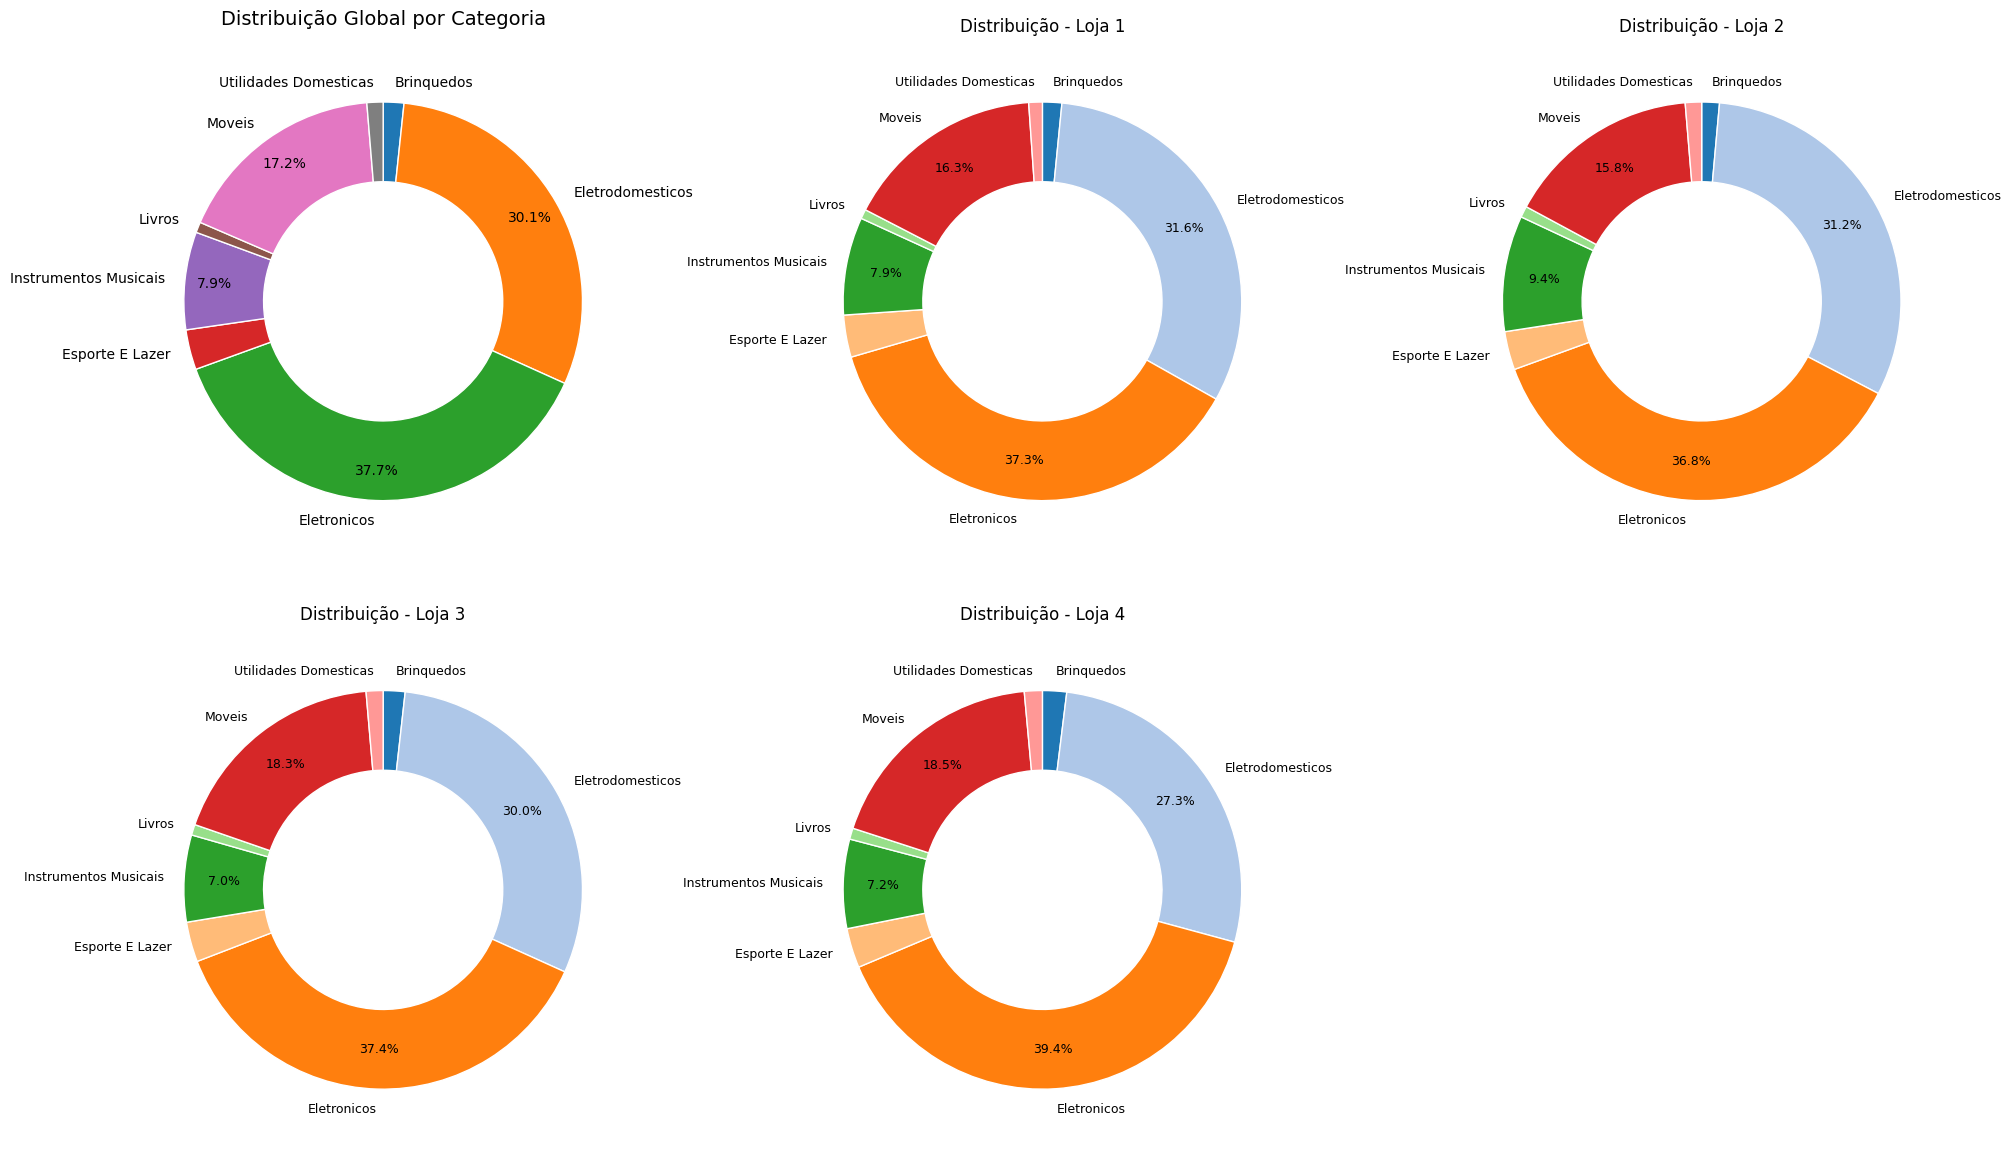

In [19]:
def preparar_dados(lojas):
    df_global = pd.concat(lojas.values())
    fat_global = df_global.groupby('Categoria do Produto')['Valor Total'].sum()

    fat_lojas = {}
    for nome, df in lojas.items():
        fat_lojas[nome] = df.groupby('Categoria do Produto')['Valor Total'].sum()

    return fat_global, fat_lojas

def plot_pie_charts(fat_global, fat_lojas):
    plt.figure(figsize=(20, 12))

    plt.subplot(2, 3, 1)
    fat_global.plot.pie(
        autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
        pctdistance=0.85,
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.4, 'edgecolor': 'white'},
        textprops={'fontsize': 10}
    )
    plt.title('Distribuição Global por Categoria', fontsize=14, pad=20)
    plt.ylabel('')

    cores = plt.cm.tab20.colors
    for i, (loja, dados) in enumerate(fat_lojas.items(), 2):
        plt.subplot(2, 3, i)
        dados.plot.pie(
            autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
            pctdistance=0.8,
            startangle=90,
            counterclock=False,
            colors=cores,
            wedgeprops={'width': 0.4, 'edgecolor': 'white'},
            textprops={'fontsize': 9}
        )
        plt.title(f'Distribuição - {loja}', fontsize=12, pad=15)
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

def imprimir_tabelas(fat_global, fat_lojas):
    print("\n" + "="*70)
    print("PARTICIPAÇÃO DAS CATEGORIAS - TODAS AS LOJAS".center(70))
    print("="*70)
    global_perc = (fat_global / fat_global.sum() * 100).round(1)
    global_df = pd.DataFrame({
        'Faturamento (R$)': fat_global,
        'Participação (%)': global_perc
    }).sort_values('Participação (%)', ascending=False)

    print(global_df.to_string(formatters={
        'Faturamento (R$)': lambda x: f'R$ {x:,.2f}',
        'Participação (%)': lambda x: f'{x}%'
    }))

    for loja, dados in fat_lojas.items():
        print("\n" + "="*70)
        print(f"PARTICIPAÇÃO POR CATEGORIA - {loja.upper()}".center(70))
        print("="*70)
        loja_perc = (dados / dados.sum() * 100).round(1)
        loja_df = pd.DataFrame({
            'Faturamento (R$)': dados,
            'Participação (%)': loja_perc
        }).sort_values('Participação (%)', ascending=False)

        print(loja_df.to_string(formatters={
            'Faturamento (R$)': lambda x: f'R$ {x:,.2f}',
            'Participação (%)': lambda x: f'{x}%'
        }))

fat_global, fat_lojas = preparar_dados(lojas_tratadas)

imprimir_tabelas(fat_global, fat_lojas)
plot_pie_charts(fat_global, fat_lojas)

##2.4 Análise de Produto por Categoria


Produto mais vendido por categoria
Categoria                 | Produto                        | Vendas     | Faturamento    
Moveis                    | Cômoda                         | 210        | R$ 82.085,88
Brinquedos                | Carrinho controle remoto       | 206        | R$ 20.771,83
Eletrodomesticos          | Micro-ondas                    | 206        | R$ 162.401,32
Instrumentos Musicais     | Bateria                        | 203        | R$ 207.574,09
Livros                    | Modelagem preditiva            | 200        | R$ 17.711,79
Utilidades Domesticas     | Jogo de panelas                | 200        | R$ 42.854,65
Eletronicos               | Celular Plus X42               | 198        | R$ 563.260,82
Esporte E Lazer           | Bola de basquete               | 197        | R$ 13.684,51

CAMPEÃO ABSOLUTO:
• Produto: Cômoda
• Categoria: Moveis
• Total Vendido: 210 unidades
• Faturamento Gerado: R$ 82.085,88


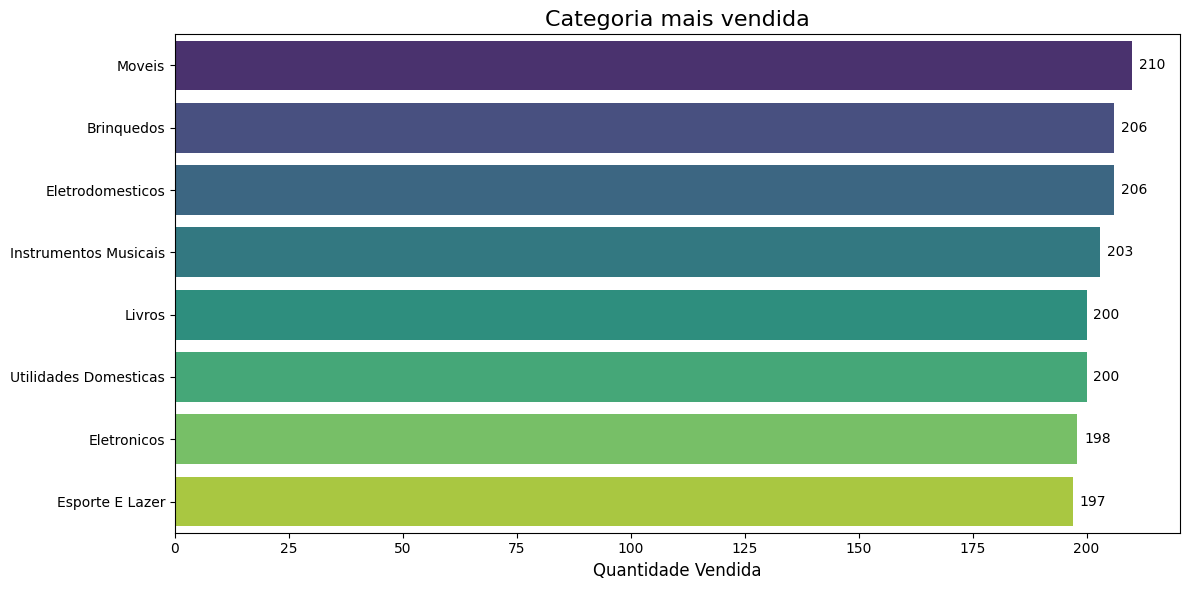

In [20]:
def formatar_moeda(valor):
    return f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def top_produto_por_categoria(lojas):
    df_total = pd.concat(lojas.values())

    if 'Quantidade' not in df_total.columns:
        df_total['Quantidade'] = 1

    produtos_agg = df_total.groupby(['Categoria do Produto', 'Produto']).agg({
        'Quantidade': 'sum',
        'Valor Total': 'sum'
    }).reset_index()

    top_produtos = produtos_agg.loc[produtos_agg.groupby('Categoria do Produto')['Quantidade'].idxmax()]

    return top_produtos.sort_values('Quantidade', ascending=False)

def plotar_top_produtos(top_produtos):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=top_produtos,
        x='Quantidade',
        y='Categoria do Produto',
        hue='Categoria do Produto',
        palette='viridis',
        legend=False
    )

    plt.title('Categoria mais vendida', fontsize=16)
    plt.xlabel('Quantidade Vendida', fontsize=12)
    plt.ylabel('', fontsize=12)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_width())}",
            (p.get_width(), p.get_y() + p.get_height()/2),
            ha='left',
            va='center',
            xytext=(5, 0),
            textcoords='offset points',
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


top_produtos = top_produto_por_categoria(lojas_tratadas)

if not top_produtos.empty:
    print("\nProduto mais vendido por categoria")
    print("=" * 90)
    print(f"{'Categoria':<25} | {'Produto':<30} | {'Vendas':<10} | {'Faturamento':<15}")
    print("=" * 90)

    for _, row in top_produtos.iterrows():
        print(f"{row['Categoria do Produto'][:24]:<25} | "
              f"{row['Produto'][:29]:<30} | "
              f"{int(row['Quantidade']):<10} | "
              f"{formatar_moeda(row['Valor Total'])}")

    campeao = top_produtos.iloc[0]
    print("\nCAMPEÃO ABSOLUTO:")
    print(f"• Produto: {campeao['Produto']}")
    print(f"• Categoria: {campeao['Categoria do Produto']}")
    print(f"• Total Vendido: {int(campeao['Quantidade'])} unidades")
    print(f"• Faturamento Gerado: {formatar_moeda(campeao['Valor Total'])}")

    plotar_top_produtos(top_produtos)
else:
    print("\n⚠️ Nenhum dado encontrado. Verifique as colunas do DataFrame.")

# 3. Média de Avaliação das Lojas


MÉDIA DE AVALIAÇÃO POR LOJA
Loja            | Média de Avaliação
Loja 3          | 4.05           
Loja 2          | 4.04           
Loja 4          | 4.00           
Loja 1          | 3.98           

DESTAQUE:
A loja com melhor avaliação média é Loja 3 com nota 4.05


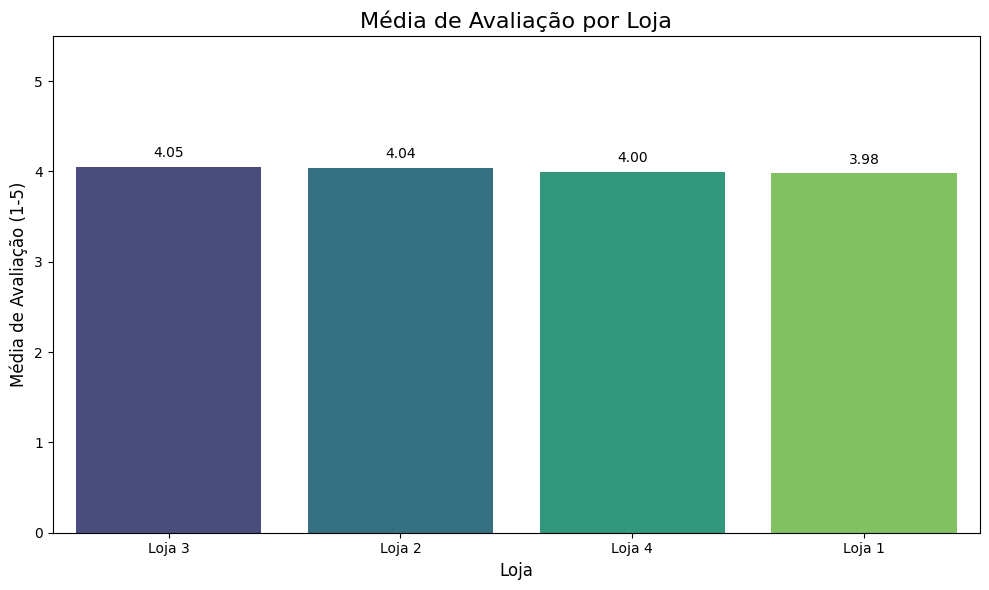

In [21]:
def calcular_media_avaliacao(lojas):
    medias = {}
    for nome_loja, df in lojas.items():
        medias[nome_loja] = df['Avaliação da compra'].mean()
    return medias

def formatar_numero(valor):
    return f"{valor:.2f}"

def plotar_avaliacoes(medias):
    plt.figure(figsize=(10, 6))
    medias_series = pd.Series(medias).sort_values(ascending=False)

    ax = sns.barplot(
        x=medias_series.index,
        y=medias_series.values,
        hue=medias_series.index,
        palette="viridis",
        legend=False
    )

    plt.title('Média de Avaliação por Loja', fontsize=16)
    plt.xlabel('Loja', fontsize=12)
    plt.ylabel('Média de Avaliação (1-5)', fontsize=12)
    plt.ylim(0, 5.5)

    for p in ax.patches:
        ax.annotate(
            formatar_numero(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

medias_avaliacao = calcular_media_avaliacao(lojas_tratadas)

print("\nMÉDIA DE AVALIAÇÃO POR LOJA")
print("="*40)
print(f"{'Loja':<15} | {'Média de Avaliação':<15}")
print("="*40)
for loja, media in sorted(medias_avaliacao.items(), key=lambda x: x[1], reverse=True):
    print(f"{loja:<15} | {formatar_numero(media):<15}")

melhor_loja = max(medias_avaliacao.items(), key=lambda x: x[1])
print("\nDESTAQUE:")
print(f"A loja com melhor avaliação média é {melhor_loja[0]} com nota {formatar_numero(melhor_loja[1])}")

plotar_avaliacoes(medias_avaliacao)

# 4. Produtos Mais e Menos Vendidos

In [22]:
def produtos_mais_menos_vendidos(lojas):
    df_total = pd.concat(lojas.values())

    if 'Quantidade' not in df_total.columns:
        df_total['Quantidade'] = 1

    produtos = df_total.groupby('Produto').agg({
        'Quantidade': 'sum',
        'Valor Total': 'sum'
    }).reset_index()

    mais_vendidos = produtos.nlargest(5, 'Quantidade')
    menos_vendidos = produtos.nsmallest(5, 'Quantidade')

    return mais_vendidos, menos_vendidos

def formatar_moeda(valor):
    return f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def plotar_produtos(mais_vendidos, menos_vendidos):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(data=mais_vendidos, x='Quantidade', y='Produto', palette='Greens_d', ax=ax1)
    ax1.set_title('Top 5 Produtos Mais Vendidos', fontsize=14)
    ax1.set_xlabel('Quantidade Vendida')
    ax1.set_ylabel('')

    for p in ax1.patches:
        ax1.annotate(f"{int(p.get_width())}",
                    (p.get_width(), p.get_y() + p.get_height()/2),
                    ha='left', va='center', xytext=(5, 0), textcoords='offset points')

    sns.barplot(data=menos_vendidos, x='Quantidade', y='Produto', palette='Reds_d', ax=ax2)
    ax2.set_title('Top 5 Produtos Menos Vendidos', fontsize=14)
    ax2.set_xlabel('Quantidade Vendida')
    ax2.set_ylabel('')

    for p in ax2.patches:
        ax2.annotate(f"{int(p.get_width())}",
                    (p.get_width(), p.get_y() + p.get_height()/2),
                    ha='left', va='center', xytext=(5, 0), textcoords='offset points')

    plt.tight_layout()
    plt.show()

mais_vendidos, menos_vendidos = produtos_mais_menos_vendidos(lojas_tratadas)

print("\nPRODUTOS MAIS VENDIDOS")
print("="*70)
print(f"{'Produto':<40} | {'Quantidade':<10} | {'Faturamento':<15}")
print("="*70)
for _, row in mais_vendidos.iterrows():
    print(f"{row['Produto'][:39]:<40} | {int(row['Quantidade']):<10} | {formatar_moeda(row['Valor Total'])}")

print("\nPRODUTOS MENOS VENDIDOS")
print("="*70)
print(f"{'Produto':<40} | {'Quantidade':<10} | {'Faturamento':<15}")
print("="*70)
for _, row in menos_vendidos.iterrows():
    print(f"{row['Produto'][:39]:<40} | {int(row['Quantidade']):<10} | {formatar_moeda(row['Valor Total'])}")

print("\nDESTAQUES:")
print(f"Produto mais vendido: {mais_vendidos.iloc[0]['Produto']} ({int(mais_vendidos.iloc[0]['Quantidade'])} unidades)")
print(f"Produto menos vendido: {menos_vendidos.iloc[0]['Produto']} ({int(menos_vendidos.iloc[0]['Quantidade'])} unidades)")


PRODUTOS MAIS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Cômoda                                   | 210        | R$ 82.085,88
Carrinho controle remoto                 | 206        | R$ 20.771,83
Micro-ondas                              | 206        | R$ 162.401,32
Bateria                                  | 203        | R$ 207.574,09
Cama king                                | 201        | R$ 190.711,14

PRODUTOS MENOS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Celular ABXY                             | 157        | R$ 221.763,77
Headset                                  | 158        | R$ 31.952,44
Mochila                                  | 163        | R$ 22.531,29
Guitarra                                 | 165        | R$ 181.682,31
Ciência de dados com python              | 166        | R$ 12.686,42

DESTAQUES:
Produto mais vendido: Cômoda (210 unidades)
Produto menos vendido: Celular ABXY (157 unidades)


## 4.1 Produto Mais Vendido Por Loja


LOJA: Loja 1

PRODUTOS MAIS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Guarda roupas                            | 60         | R$ 41.368,12
Micro-ondas                              | 60         | R$ 48.773,55
TV Led UHD 4K                            | 60         | R$ 199.655,82
Secadora de roupas                       | 58         | R$ 82.955,11
Blocos de montar                         | 56         | R$ 2.610,59

PRODUTOS MENOS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Celular ABXY                             | 33         | R$ 45.864,60
Headset                                  | 33         | R$ 6.669,36
Panela de pressão                        | 35         | R$ 3.683,78
Pandeiro                                 | 36         | R$ 3.150,86
Ciência de dados com python              | 39         | R$ 2.892,92

DESTAQUES:
Produto mais vendido: Guarda roupas (60 unidades)
Produto menos vendido: Celular ABXY (33 unida

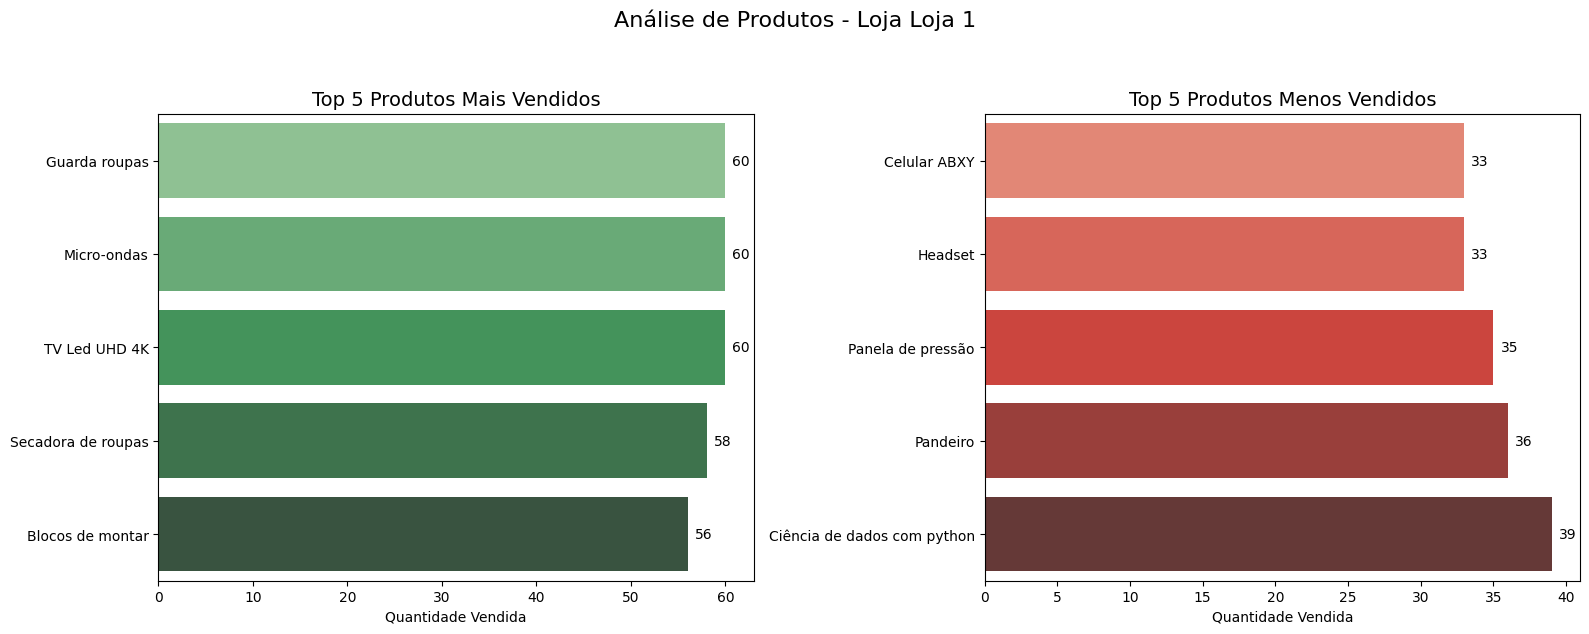


LOJA: Loja 2

PRODUTOS MAIS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Iniciando em programação                 | 65         | R$ 4.386,64
Micro-ondas                              | 62         | R$ 50.824,49
Bateria                                  | 61         | R$ 64.853,14
Pandeiro                                 | 58         | R$ 5.203,16
Violão                                   | 58         | R$ 26.188,65

PRODUTOS MENOS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Jogo de tabuleiro                        | 32         | R$ 8.158,01
Impressora                               | 34         | R$ 14.597,92
Mesa de jantar                           | 34         | R$ 12.147,60
Poltrona                                 | 35         | R$ 11.822,78
Fone de ouvido                           | 37         | R$ 4.977,17

DESTAQUES:
Produto mais vendido: Iniciando em programação (65 unidades)
Produto menos vendido: Jogo de tab

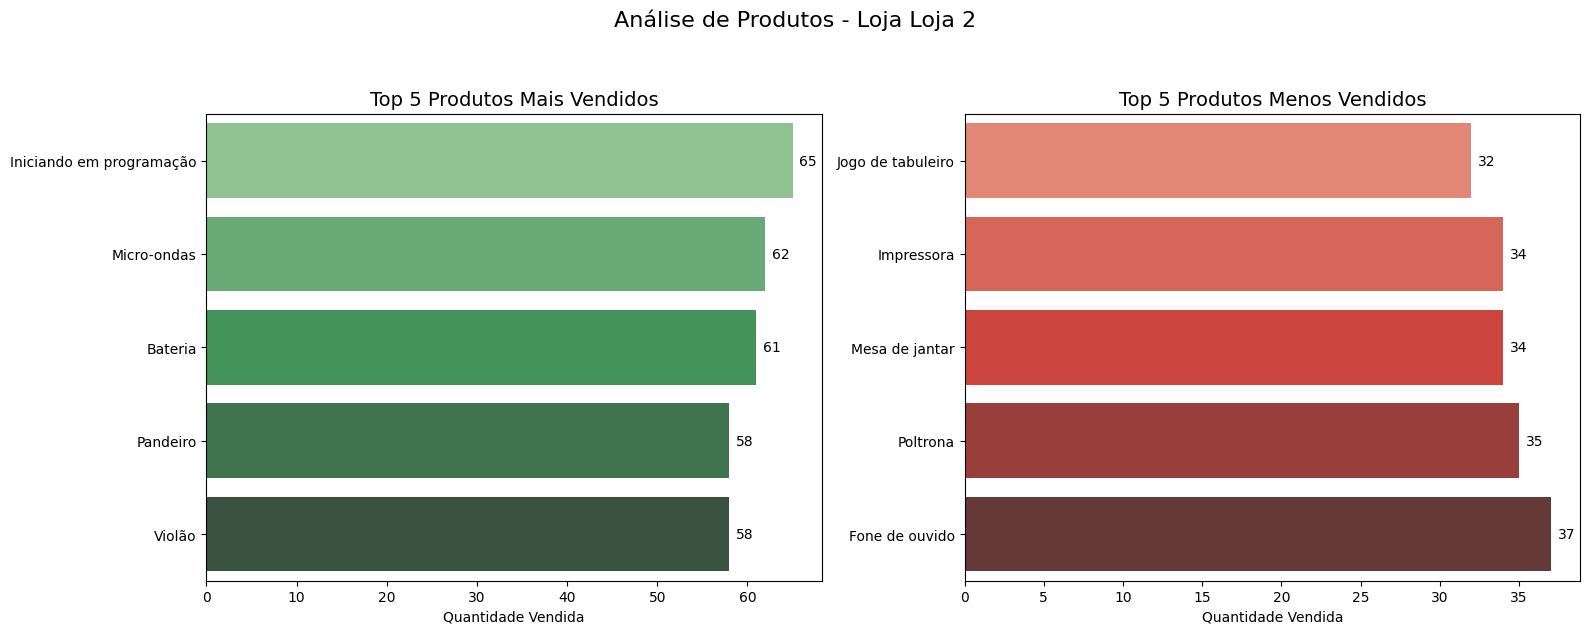


LOJA: Loja 3

PRODUTOS MAIS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Kit banquetas                            | 57         | R$ 23.465,64
Cama king                                | 56         | R$ 54.582,60
Mesa de jantar                           | 56         | R$ 20.103,82
Cômoda                                   | 55         | R$ 21.567,70
Jogo de panelas                          | 55         | R$ 12.226,32

PRODUTOS MENOS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Blocos de montar                         | 35         | R$ 1.718,10
Jogo de copos                            | 36         | R$ 1.710,91
Micro-ondas                              | 36         | R$ 26.883,71
Mochila                                  | 36         | R$ 4.971,78
Copo térmico                             | 38         | R$ 2.433,88

DESTAQUES:
Produto mais vendido: Kit banquetas (57 unidades)
Produto menos vendido: Blocos de montar (35 u

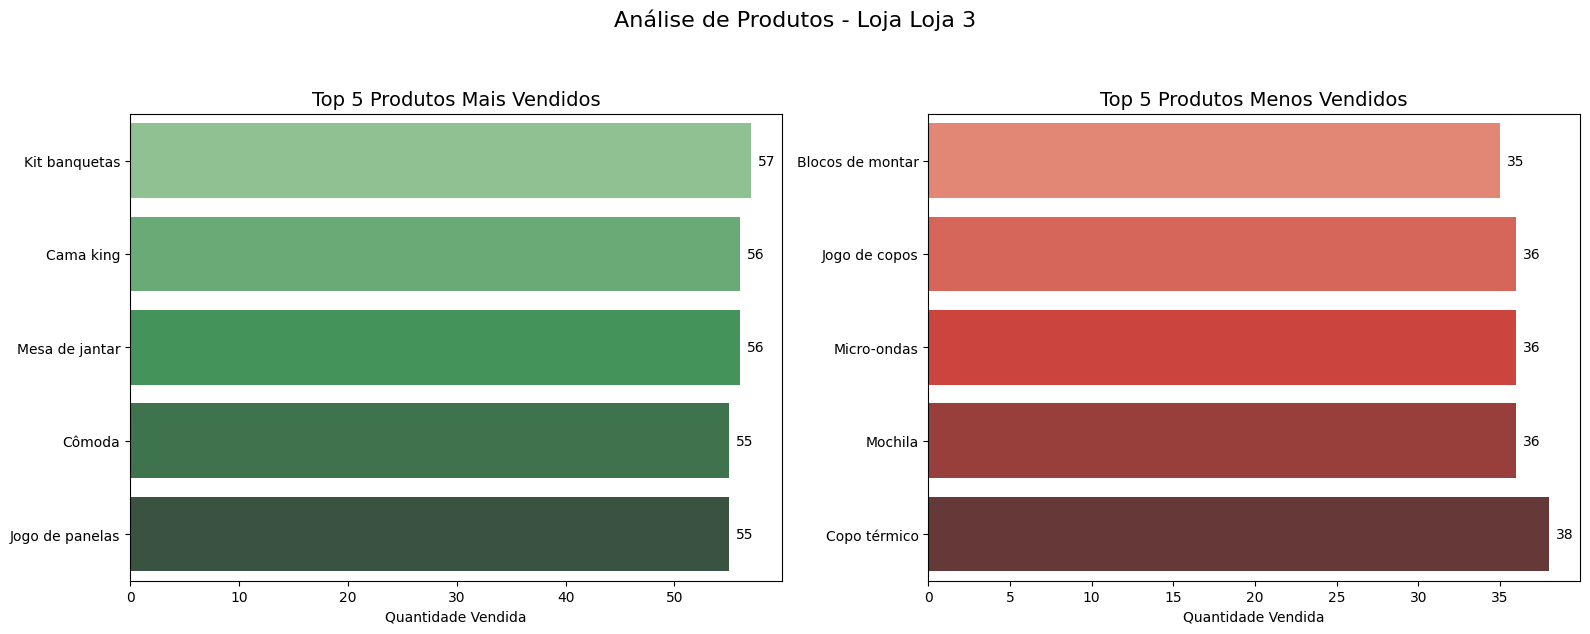


LOJA: Loja 4

PRODUTOS MAIS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Cama box                                 | 62         | R$ 46.264,14
Faqueiro                                 | 59         | R$ 3.722,61
Cama king                                | 56         | R$ 52.748,19
Dashboards com Power BI                  | 56         | R$ 2.832,74
Carrinho controle remoto                 | 55         | R$ 5.647,64

PRODUTOS MENOS VENDIDOS
Produto                                  | Quantidade | Faturamento    
Guitarra                                 | 33         | R$ 36.232,51
Guarda roupas                            | 34         | R$ 23.056,33
Violão                                   | 37         | R$ 15.796,34
Ciência de dados com python              | 38         | R$ 2.985,73
Geladeira                                | 38         | R$ 105.681,06

DESTAQUES:
Produto mais vendido: Cama box (62 unidades)
Produto menos vendido: Guitarra (33 unidades)




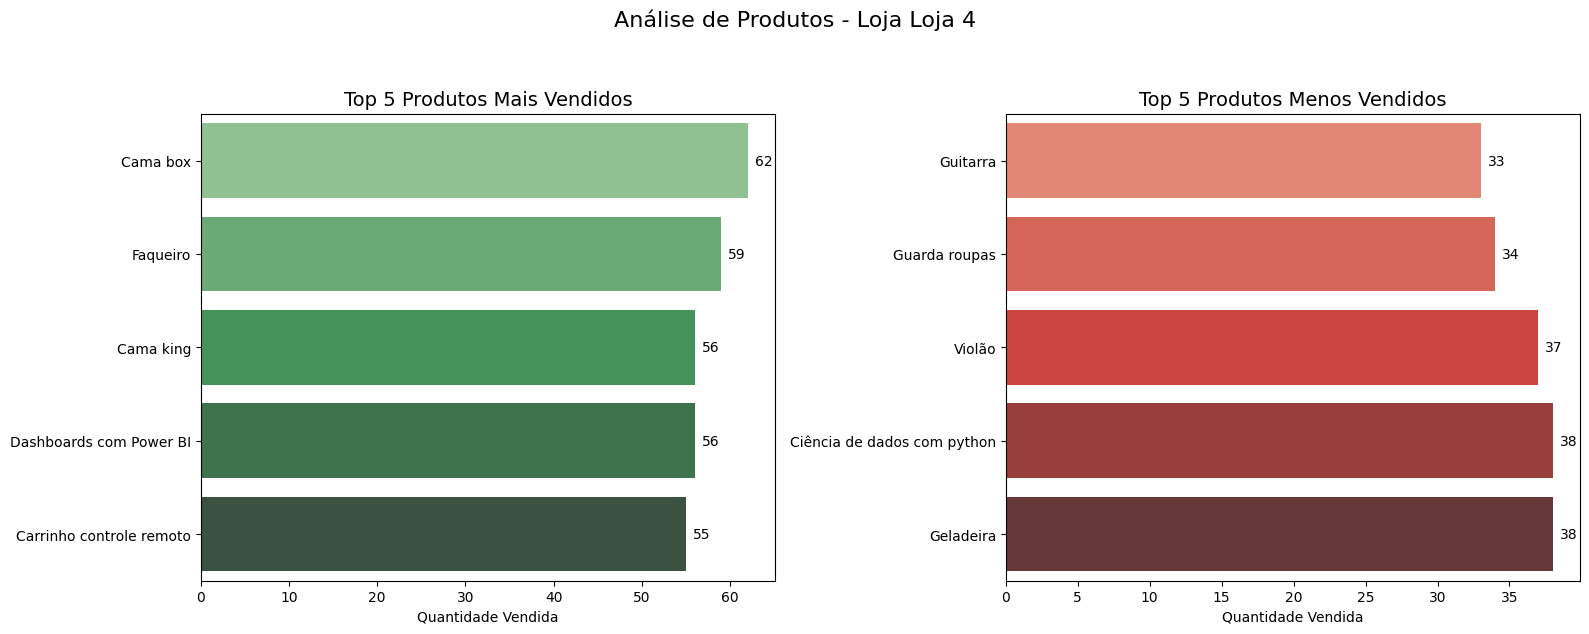

In [23]:
def produtos_mais_menos_vendidos_por_loja(lojas):
    resultados = {}

    for nome_loja, df_loja in lojas.items():
        if 'Quantidade' not in df_loja.columns:
            df_loja['Quantidade'] = 1

        produtos = df_loja.groupby('Produto').agg({
            'Quantidade': 'sum',
            'Valor Total': 'sum'
        }).reset_index()

        mais_vendidos = produtos.nlargest(5, 'Quantidade')
        menos_vendidos = produtos.nsmallest(5, 'Quantidade')

        resultados[nome_loja] = (mais_vendidos, menos_vendidos)

    return resultados

def plotar_produtos_por_loja(resultados_por_loja):
  for loja, (mais_vendidos, menos_vendidos) in resultados_por_loja.items():
        print(f"\nLOJA: {loja}")
        print("\nPRODUTOS MAIS VENDIDOS")
        print("="*70)
        print(f"{'Produto':<40} | {'Quantidade':<10} | {'Faturamento':<15}")
        print("="*70)
        for _, row in mais_vendidos.iterrows():
            print(f"{row['Produto'][:39]:<40} | {int(row['Quantidade']):<10} | {formatar_moeda(row['Valor Total'])}")

        print("\nPRODUTOS MENOS VENDIDOS")
        print("="*70)
        print(f"{'Produto':<40} | {'Quantidade':<10} | {'Faturamento':<15}")
        print("="*70)
        for _, row in menos_vendidos.iterrows():
            print(f"{row['Produto'][:39]:<40} | {int(row['Quantidade']):<10} | {formatar_moeda(row['Valor Total'])}")

        print("\nDESTAQUES:")
        print(f"Produto mais vendido: {mais_vendidos.iloc[0]['Produto']} ({int(mais_vendidos.iloc[0]['Quantidade'])} unidades)")
        print(f"Produto menos vendido: {menos_vendidos.iloc[0]['Produto']} ({int(menos_vendidos.iloc[0]['Quantidade'])} unidades)")
        print("\n" + "="*70 + "\n")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Análise de Produtos - Loja {loja}', fontsize=16, y=1.05)

        sns.barplot(data=mais_vendidos, x='Quantidade', y='Produto',
                   hue='Produto', palette='Greens_d', ax=ax1, legend=False)
        ax1.set_title('Top 5 Produtos Mais Vendidos', fontsize=14)
        ax1.set_xlabel('Quantidade Vendida')
        ax1.set_ylabel('')

        for p in ax1.patches:
            ax1.annotate(f"{int(p.get_width())}",
                        (p.get_width(), p.get_y() + p.get_height()/2),
                        ha='left', va='center', xytext=(5, 0), textcoords='offset points')

        sns.barplot(data=menos_vendidos, x='Quantidade', y='Produto',
                   hue='Produto', palette='Reds_d', ax=ax2, legend=False)
        ax2.set_title('Top 5 Produtos Menos Vendidos', fontsize=14)
        ax2.set_xlabel('Quantidade Vendida')
        ax2.set_ylabel('')

        for p in ax2.patches:
            ax2.annotate(f"{int(p.get_width())}",
                        (p.get_width(), p.get_y() + p.get_height()/2),
                        ha='left', va='center', xytext=(5, 0), textcoords='offset points')

        plt.tight_layout()
        plt.show()


resultados_por_loja = produtos_mais_menos_vendidos_por_loja(lojas_tratadas)
plotar_produtos_por_loja(resultados_por_loja)

# 5. Frete Médio por Loja


====================FRETE MÉDIO POR LOJA====================

Loja                           | Frete Médio (R$)
------------------------------------------------
Loja 1                         |        R$ 34,69
Loja 2                         |        R$ 33,62
Loja 3                         |        R$ 33,07
Loja 4                         |        R$ 31,28

------------------------------------------------
Média Geral                    |        R$ 33,17
Maior Frete                    |        R$ 34,69 (Loja 1)
Menor Frete                    |        R$ 31,28 (Loja 4)


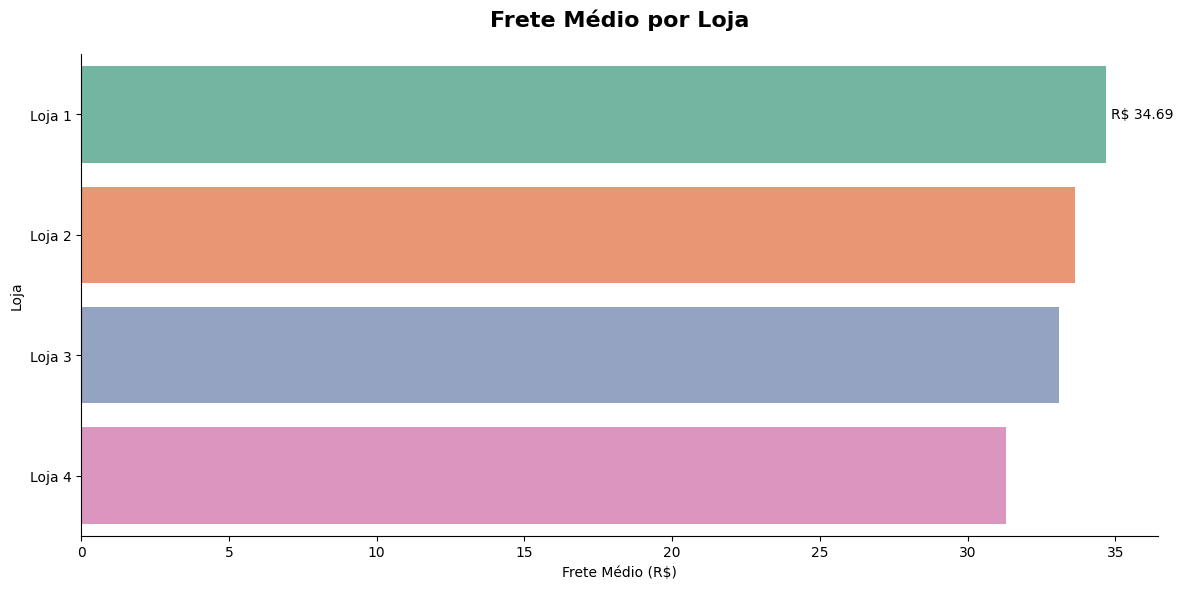

In [24]:
def frete_medio_por_loja(lojas):
    fretes = {}

    for nome_loja, df_loja in lojas.items():
        if 'Frete' in df_loja.columns:
            frete_medio = df_loja['Frete'].mean()
            fretes[nome_loja] = frete_medio

    if not fretes:
        print("Nenhum dado de frete encontrado nas lojas.")
        return

    df_resultado = pd.DataFrame.from_dict(fretes, orient='index', columns=['Frete Médio'])
    df_resultado = df_resultado.sort_values('Frete Médio', ascending=False)

    print("FRETE MÉDIO POR LOJA".center(60, '='))
    print(f"\n{'Loja':<30} | {'Frete Médio (R$)':>15}")
    print("-" * 48)

    for loja, valor in df_resultado.itertuples():
        print(f"{loja:<30} | {formatar_moeda(valor):>15}")

    print("\n" + "-" * 48)
    print(f"{'Média Geral':<30} | {formatar_moeda(df_resultado['Frete Médio'].mean()):>15}")
    print(f"{'Maior Frete':<30} | {formatar_moeda(df_resultado['Frete Médio'].max()):>15} ({df_resultado.index[0]})")
    print(f"{'Menor Frete':<30} | {formatar_moeda(df_resultado['Frete Médio'].min()):>15} ({df_resultado.index[-1]})")
    print("=" * 60)


    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='Frete Médio',
        y=df_resultado.index,
        data=df_resultado.reset_index(),
        palette="Set2",
        hue=df_resultado.index,
        legend=False
    )
    ax.set_title("Frete Médio por Loja", fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Frete Médio (R$)")
    ax.set_ylabel("Loja")
    ax.bar_label(ax.containers[0], fmt='R$ %.2f', padding=3)
    plt.tight_layout()
    sns.despine()
    plt.show()

def formatar_moeda(valor):
    return f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

frete_medio_por_loja(lojas_tratadas)


# 6. Análise Geográfica

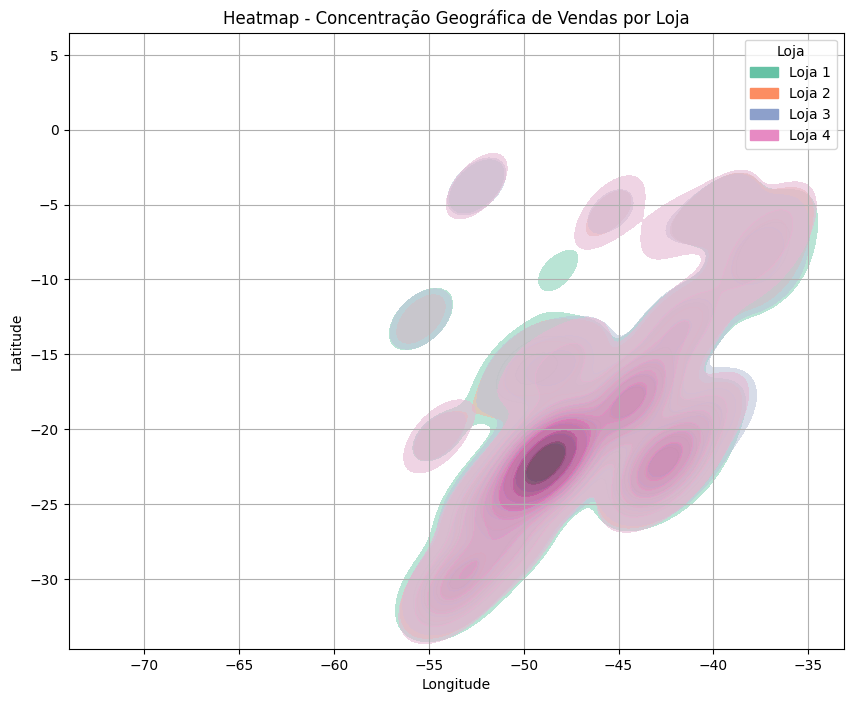

Vendas por Região:

Lojas            |Loja 1   |Loja 2   |Loja 3   |Loja 4   |
----------------------------------------------------------
AC               |2444     |113      |394      |0        |
AL               |11285    |4953     |9125     |1822     |
AM               |1570     |1541     |3661     |1486     |
AP               |1375     |0        |457      |2143     |
BA               |46248    |38929    |51637    |48618    |
CE               |18561    |19431    |18021    |18560    |
DF               |31328    |30241    |47964    |34273    |
ES               |19607    |17304    |49651    |25947    |
GO               |53234    |40726    |35320    |10303    |
MA               |4338     |10524    |11053    |17211    |
MG               |174677   |201111   |177182   |174715   |
MS               |12427    |11663    |11972    |18029    |
MT               |16264    |12169    |15943    |6820     |
PA               |13555    |6100     |14751    |15249    |
PB               |13411    |6889    


Loja com maior faturamento: Loja 1 (R$ 1,616,346.99)
Estado com maior faturamento: SP


In [29]:
def analise_geografica_completa(lojas):

    df_total = pd.DataFrame()
    for nome_loja, df in lojas.items():
        if isinstance(df, str):
            df = pd.read_csv(df)
        df['Loja'] = nome_loja
        df_total = pd.concat([df_total, df], ignore_index=True)

    if not {'lat', 'lon', 'Valor Total'}.issubset(df_total.columns):
        print("Dados geográficos ou de valor não encontrados.")
        return None

    fig1 = px.scatter_geo(
        df_total,
        lat='lat',
        lon='lon',
        color='Loja',
        size='Valor Total',
        hover_name='Produto' if 'Produto' in df_total.columns else 'Loja',
        scope='south america',
        title='Distribuição Geográfica das Vendas por Loja'
    )
    fig1.update_layout(height=600)
    fig1.show()

    plt.figure(figsize=(10, 8))
    sns.kdeplot(
        data=df_total,
        x='lon', y='lat',
        hue='Loja',
        fill=True,
        common_norm=False,
        alpha=0.6,
        palette='Set2',
        weights='Valor Total' if 'Valor Total' in df_total.columns else None
    )
    plt.title('Heatmap - Concentração Geográfica de Vendas por Loja')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    if 'Local da compra' in df_total.columns:
        desempenho = df_total.groupby(['Local da compra', 'Loja'])['Valor Total'].sum().reset_index(name='Total Vendas')
        pivot = desempenho.pivot(index='Local da compra', columns='Loja', values='Total Vendas').fillna(0).astype(int)
        print("Vendas por Região:\n")


        pivot_formatado = pivot.reset_index()

        header = f"{'Lojas':<17}|" + "".join([f"{col:<9}|" for col in pivot.columns])
        print(header)
        print("-" * len(header))


        for _, row in pivot_formatado.iterrows():
            linha = f"{row['Local da compra']:<17}|" + "".join([f"{int(row[col]):<9}|" for col in pivot.columns])
            print(linha)


    dados_geo = []
    for nome_loja, df in lojas.items():
        if isinstance(df, str):
            df = pd.read_csv(df)
        if {'lat', 'lon', 'Valor Total'}.issubset(df.columns):
            dados_geo.append({
                'Loja': nome_loja,
                'Latitude': df['lat'].mean(),
                'Longitude': df['lon'].mean(),
                'Total Vendas': df['Valor Total'].sum(),
                'Qtd Vendas': len(df),
                'Rating Médio': df['Avaliação'].mean() if 'Avaliação' in df.columns else None
            })

    if dados_geo:
        df_geo = pd.DataFrame(dados_geo)

        mapa = folium.Map(location=[df_geo['Latitude'].mean(), df_geo['Longitude'].mean()], zoom_start=12)

        heat_data = [[row['Latitude'], row['Longitude'], row['Total Vendas']] for _, row in df_geo.iterrows()]
        HeatMap(heat_data, radius=15).add_to(mapa)

        for _, row in df_geo.iterrows():
            popup_content = f"""
            <b>Loja:</b> {row['Loja']}<br>
            <b>Total Vendas:</b> R$ {row['Total Vendas']:,.2f}<br>
            <b>Qtd Vendas:</b> {row['Qtd Vendas']}<br>
            """
            if pd.notna(row['Rating Médio']):
                popup_content += f"<b>Avaliação Média:</b> {row['Rating Médio']:.1f}/5.0"

            folium.CircleMarker(
                location=[row['Latitude'], row['Longitude']],
                radius=row['Total Vendas']/df_geo['Total Vendas'].max()*15,
                popup=popup_content,
                color='blue',
                fill=True,
                fill_color='blue'
            ).add_to(mapa)

        display(mapa)
        mapa.save('mapa_vendas_folium.html')

    if not df_total.empty:
        mais_vendida = df_total.groupby('Loja')['Valor Total'].sum().sort_values(ascending=False)
        print("\nLoja com maior faturamento:", mais_vendida.idxmax(), f"(R$ {mais_vendida.max():,.2f})")

        if 'Local da compra' in df_total.columns:
            top_regiao = df_total.groupby('Local da compra')['Valor Total'].sum().idxmax()
            print("Estado com maior faturamento:", top_regiao)

    return df_total if not df_total.empty else None


df_resultados = analise_geografica_completa(lojas_tratadas)

#Relatório

Após análise detalhada dos dados fornecidos segue o relatório sugestivo de venda de uma das lojas do Sr. João
## Quadro Comparativo Geral

| Indicador               | Loja 2          | Loja 1          | Loja 4          | Loja 3          |
|-------------------------|----------------|----------------|----------------|----------------|
| **Faturamento Total**   | R\$ 1.567.773,29 | R\$ 1.616.346,99 | R\$ 1.458.253,56 | R$ 1.542.047,52 |
| **Ranking Faturamento** |      3º        |      1º        |      4º        |      2º        |
| **Crescimento Médio**   | 2.8%           | 3.5%           | 5.0%           | **5.4%**       |
| **Meses Positivos**     | 18/38 (47%)    | 19/38 (50%)    | 21/38 (55%)    | 19/38 (50%)    |
| **Última Variação**     | **-20.7%**     | -0.3%          | -8.4%          | **+28.1%**     |


## Análise Individual Comparada

### 1. Loja 2 vs Loja 3 (Melhor Performance)
- **Crescimento**: 2.8% vs **5.4%** (Loja 3 cresce 93% mais rápido)
- **Recuperação**: Queda de -20.7% vs Alta de **+28.1%** no último mês
- **Consistência**: 47% vs 50% de meses positivos

### 2. Loja 2 vs Loja 4
- **Faturamento**: +7.5% maior (R\$ 1.56M vs R\$ 1.45M)
- **Crescimento**: 2.8% vs **5.0%** (Loja 4 cresce 79% mais)
- **Resiliência**: 47% vs **55%** de meses positivos

### 3. Loja 1 vs Loja 3
- **Faturamento**: +4.8% maior (R\$ 1.61M vs R\$ 1.54M)
- **Crescimento**: 3.5% vs **5.4%** (Loja 3 mais dinâmica)
- **Último Mês**: -0.3% vs **+28.1%** (Loja 3 mostra grande recuperação)

### 4. Loja 4 vs Loja 3
- **Faturamento**: -5.7% menor (R\$ 1.45M vs R\$ 1.54M)
- **Crescimento**: 5.0% vs **5.4%** (similar)
- **Consistência**: **55%** vs 50% de meses positivos

## Conclusão

 **PARA VENDER**:
   - **Loja 2**: Menor crescimento (2.8%) + Queda extrema (-20.7%)
